## Imports

In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from bbtoolkit.utils.viz import plot_arrow, plot_polygon
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.attention import RhythmicAttention
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.structures.tensorgroups import DirectedTensor
from bbtoolkit.models.bb.neural_generators import MTLGenerator
import matplotlib


logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


### Define Transformation Circuit and Environment

In [2]:


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../data/envs/main_environment.pkl')
env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=[TransparentObjects()]
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

In [3]:
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor

def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out


config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = 5

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [4]:
from bbtoolkit.models.bb.neural_generators import GCMap

# trunc means not including boundaries themselves
# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_trunc_square.pkl')
# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_square_check.pkl')
mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_square_check4.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights.pkl')
# pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_trunc.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [5]:
from bbtoolkit.structures.tensorgroups import DirectedTensor


tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

In [6]:
weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [7]:
from bbtoolkit.utils.math.geometry import points2segments
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup


activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [8]:
def activity2rate(activity: TensorGroup, connectivity: DirectedTensorGroup) -> TensorGroup:
    """
    Converts the activity of a TensorGroup to firing rates using a sigmoid projection.

    Args:
        activity (TensorGroup): The activity of the neurons.
        connectivity (DirectedTensorGroup): The synaptic connectivity between the neurons.

    Returns:
        TensorGroup: The firing rates of the neurons.
    """
    rates = TensorGroup()
    for key, tensor in activity.data.items():
        key_ = 'pr' if 'pr' in key else key # object identity cells, use same beta and alpha as other PR neurons by definition
        rates.add_tensor(
            NamedTensor(
                key,
                1/(
                    1 + np.exp(-2*connectivity[key_, key_]['beta']*(tensor - connectivity[key_, key_]['alpha']))
                )
            )
        )
    return rates

In [9]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

In [10]:
from typing import Mapping


class HDCallback(BaseCallback):
    """
    A callback designed for handling head direction (HD) cues and updating HD cell activities in an agent-based learning simulation.

    This callback integrates external HD cues, manages HD cell activities based on movement and cognitive states, and updates the agent's perceived direction.

    Attributes:
        init_timesteps (int): The number of initial timesteps during which HD cues are applied.
        hd_cue_scale (float): The scale factor for HD cues.
        no_cue_reset_modes (tuple[str, ...]): Modes in which HD cues are not reset.
        total_steps (int): Counter for the steps during which HD cues are active.
        mode (str): The current mode of the simulation.
    """
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
        no_cue_reset_modes: tuple[str, ...] = ('recall', 'top-down')
    ):
        """
        Initializes the HDCallback instance with specified parameters for HD cue initialization and scaling.

        Args:
            init_timesteps (int): The number of initial timesteps during which HD cues are applied.
            hd_cue_scale (float): The scale factor for HD cues.
            no_cue_reset_modes (tuple[str, ...]): Modes in which HD cues are not reset.
        """
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None
        self.no_cue_reset_modes = no_cue_reset_modes

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for HD cue management, and initializes HD cues.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `tc_gen`: Transformation circuit generator for HD activity.
            - `movement_params`: Contains the physical movement parameters of the agent, including its current position.
            - `mental_movement_params`: Contains the mental movement parameters of the agent during cognitive navigation tasks.
            - `hd_cue`: HD cue array for external directional cues.
            - `k_ratio`: Ratio of excitation/inhibition for HD cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
        """
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'tc_gen',  # Transformation circuit generator for HD activity.
            'movement_params',  # Movement parameters including position and direction.
            'mental_movement_params',  # Mental movement parameters for cognitive navigation.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates'  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates HD cues and cell activities at the beginning of each simulation step, based on the agent's movement and cognitive state.

        Args:
            step (int): The current step number.
        """
        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        match self.dynamics_params['mode']:
            case 'bottom-up':
                params = self.movement_params
                target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
                position = self.movement_params.position
                direction = self.movement_params.direction
            case 'top-down':
                params = self.mental_movement_params
                target = self.mental_movement_params.move_target if self.mental_movement_params.move_target is not None else self.mental_movement_params.rotate_target
                position = self.mental_movement_params.position
                direction = self.mental_movement_params.direction
            case 'recall':
                params, target, position, direction = None, None, None, None

        if target is not None:
            angle_to_target = math.atan2(
                target[1] - position[1],
                target[0] - position[0]
            ) % (2*np.pi)

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            params.direction = hd_estim



In [11]:
class GCRateCallback(BaseCallback):
    """
    A callback designed to update grid cell (GC) activation rates based on the agent's current or mental position in an agent-based learning simulation.

    This callback uses the agent's physical position in bottom-up mode and the mental position in top-down or recall modes to determine the corresponding grid cell activations.

    Attributes:
        gc_map (GCMap): An instance of GCMap containing the firing rates of grid cells across different locations.
    """
    def __init__(self, gc_map: GCMap):
        """
        Initializes the GCRateCallback instance with a specified GCMap.

        Args:
            gc_map (GCMap): An instance of GCMap to be used for updating grid cell activation rates.
        """
        super().__init__()
        self.gc_map = gc_map.fr

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating GC rates, and prepares for rate updates.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `movement_params`: Contains the physical movement parameters of the agent, including its current position.
            - `mental_movement_params`: Contains the mental movement parameters of the agent during cognitive navigation tasks.
            - `rates`: A structure to store the updated grid cell activation rates.
            - `grid2cart`: A mapping function or structure to convert grid indices to Cartesian coordinates.
        """
        self.requires = [
            'dynamics_params',
            'movement_params',
            'mental_movement_params',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)

    def get_grid_location(self, x: float, y: float) -> tuple[int, int]:
        """
        Converts Cartesian coordinates to grid indices.

        Args:
            x (float): The x-coordinate.
            y (float): The y-coordinate.

        Returns:
            tuple[int, int]: The corresponding grid indices.
        """
        return self.cache.grid2cart(x, y)

    def on_step_begin(self, step: int):
        """
        Updates the grid cell activation rates at the beginning of each simulation step, based on the agent's current or mental position.

        Args:
            step (int): The current step number.
        """
        match self.dynamics_params.mode:
            case 'bottom-up':
                if self.movement_params.position is not None:
                    self.rates.gc = np.reshape(self.gc_map[*self.get_grid_location(*self.movement_params.position)], (-1, 1))
            case 'top-down' | 'recall':
                if self.mental_movement_params.position is not None:
                    self.rates.gc = np.reshape(self.gc_map[*self.get_grid_location(*self.mental_movement_params.position)], (-1, 1))


class PCCallback(BaseCallback):
    """
    A callback designed to update place cell (PC) dynamics in an agent-based learning simulation.

    This callback computes the activity and rates of place cells based on various inputs and connectivity parameters, adjusting for intrinsic competition among cells.

    Attributes:
        i_comp (float): The initial value for inhibitory compencation.
        i_comp_scale (float): The addictive scaling factor for inhibitory compencation adjustment.
    """
    def __init__(self, i_comp: float = 0, i_comp_scale: float = 15):
        """
        Initializes the PCCallback instance with specified parameters for intrinsic competition.

        Args:
            i_comp (float): The initial value for inhibitory compencation.
            i_comp_scale (float): The scaling factor for inhibitory compencation adjustment.
        """
        super().__init__()
        self.i_comp = i_comp
        self.i_comp_scale = i_comp_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, adds a tensor for intrinsic competition, and specifies the required cache keys for PC dynamics update.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for PC cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
            - `grid2cart`: A mapping function or structure to convert grid indices to Cartesian coordinates.
        """
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the activity and rates of place cells at the beginning of each simulation step, based on the current mode of operation and intrinsic competition among cells.

        Args:
            step (int): The current step number.
        """
        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.h.to.h['phi']*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.rates.i_comp
        )
        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.cache['k_ratio'].h += self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc
            case 'recall':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr
            case 'top-down':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr +\
                    self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc

        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        # FIXME: What is the 15 in the equation?
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(self.i_comp_scale - np.sum(self.rates.h))


In [12]:
class BVCCallback(BaseCallback):
    """
    A callback designed to update the Border Vector Cell (BVC) activity and rates based on the current dynamics of the simulation.

    This callback calculates the BVC activity and rates by considering inputs from various sources, including other BVCs, Object Vector Cells (OVCs), Place Cells (PCs), and possibly others depending on the simulation mode.

    Attributes:
        Requires various parameters from the cache to compute the BVC activity and rates, including dynamics parameters, connectivity, and weights.
    """
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating BVC activity and rates, and prepares for computation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for BVC cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
        """
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the BVC activity and rates at the beginning of each simulation step, based on the current dynamics and mode of operation.

        Args:
            step (int): The current step number.
        """
        self.k_ratio.bvc = (
            - self.activity.bvc
            + self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc
            + self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc
            + self.connectivity.pr.to.bvc['phi']*self.weights.pr.to.bvc @ self.rates.pr
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.bvc += self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)
            case 'recall' | 'top-down':
                self.k_ratio.bvc += self.connectivity.h.to.bvc['phi']*self.weights.h.to.bvc @ self.rates.h

        self.activity.bvc += self.dt/self.connectivity.bvc.to.bvc['tau']*self.k_ratio.bvc

        self.rates.bvc = 1/(1 + np.exp(-2*self.connectivity.bvc.to.bvc['beta']*(self.activity.bvc - self.connectivity.bvc.to.bvc['alpha'])))


In [13]:
class OVCCallback(BaseCallback):
    """
    A callback designed to update the Object Vector Cells (OVC) based on various inputs and connectivity in an agent-based learning simulation.

    This callback computes the activity and rates of OVCs by integrating inputs from different sources according to the current mode of the simulation.

    Attributes:
        Requires various parameters from the cache to compute the updates for OVCs, including dynamics parameters, connectivity, weights, and rates from other cell types.
    """
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating OVCs, and prepares for computation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the activity and rates of OVCs at the beginning of each simulation step, based on the current dynamics parameters and inputs from various sources.

        Args:
            step (int): The current step number.
        """
        self.k_ratio.ovc = (
            - self.activity.ovc
            + self.connectivity.ovc.to.ovc['phi']*self.weights.ovc.to.ovc @ self.rates.ovc
            + self.connectivity.bvc.to.ovc['phi']*self.weights.bvc.to.ovc @ self.rates.bvc
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.ovc += self.connectivity.tr.to.ovc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.otr, axis=0)
            case 'recall' | 'top-down':
                self.k_ratio.ovc += (
                    self.connectivity.opr.to.ovc['phi']*self.weights.opr.to.ovc @ self.rates.opr
                    + self.connectivity.h.to.ovc['phi']*self.weights.h.to.ovc @ self.rates.h
                )

        self.activity.ovc += self.dt/self.connectivity.ovc.to.ovc['tau']*self.k_ratio.ovc

        self.rates.ovc = 1/(1 + np.exp(-2*self.connectivity.ovc.to.ovc['beta']*(self.activity.ovc - self.connectivity.ovc.to.ovc['alpha'])))


In [14]:
def get_pr_cue(env: Environment, walls_fov: list[np.ndarray]) -> np.ndarray:
    """
    Generates a perirhinal (PR) cue vector based on the visibility and distance of walls within the field of view.

    Args:
        env (Environment): The simulation environment containing walls and their textures.
        walls_fov (list[np.ndarray]): A list of numpy arrays, each representing the points of a wall that are within the field of view.

    Returns:
        np.ndarray: The PR cue vector, where each element represents a normalized count of points for each texture, adjusted by the minimum distance to the observer.
    """
    # 1. get amount of points for each texture id
    counts = dict()
    distances = dict()
    for wall, wall_fov in zip(env.walls, walls_fov):
        if wall.polygon.texture.id_ not in counts:
            counts[wall.polygon.texture.id_] = len(wall_fov)
            d = np.sqrt(np.sum(wall_fov**2, axis=1))
            if d.size:
                distances[wall.polygon.texture.id_] = np.min(d)
            else:
                distances[wall.polygon.texture.id_] = np.inf
        else:
            counts[wall.polygon.texture.id_] += len(wall_fov)
            distances[wall.polygon.texture.id_] = min(distances[wall.polygon.texture.id_], np.min(np.sqrt(np.sum(wall_fov**2, axis=1))))

    distances = dict(sorted(distances.items(), key=lambda x: x[0])) # walls with smallest id first
    counts = dict(sorted(counts.items(), key=lambda x: x[0]))
    # 2. get the pr cue vector which is counts normalized by the distance
    pr_cue = np.array([count/dist for count, dist in zip(counts.values(), distances.values())])

    return pr_cue

In [15]:
class PRCallback(BaseCallback):
    """
    A callback designed to update perirhinal cortex (PR) related parameters and activities in an agent-based learning simulation.

    This callback computes the PR cue from environmental inputs, updates the k-ratio for PR neurons based on various inputs and connectivity, and finally updates the PR neuron rates.

    Attributes:
        pr_cue_scale (float): A scaling factor for the PR cue to adjust its influence on the PR neuron activities.
    """
    def __init__(self, pr_cue_scale: float = 50):
        """
        Initializes the PRCallback instance with a specified PR cue scale.

        Args:
            pr_cue_scale (float): The scaling factor for the PR cue.
        """
        super().__init__()
        self.pr_cue_scale = pr_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating PR parameters, and prepares for PR cue computation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `env`: The simulation environment containing walls and their textures.
            - `walls_fov`: A list of numpy arrays, each representing the points of a wall that are within the field of view.
            - `k_ratio`: Ratio of excitation/inhibition for PR cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
        """
        self.requires = [
            'dynamics_params',
            'env',
            'walls_fov',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the PR cue, k-ratio, activity, and rates at the beginning of each simulation step, based on the current environmental inputs and connectivity.

        Args:
            step (int): The current step number.
        """
        pr_cue = get_pr_cue(self.env, self.walls_fov)[:, np.newaxis]

        self.pr_cue = self.pr_cue_scale*pr_cue/np.max(pr_cue)

        self.k_ratio.pr = -self.activity.pr +\
            self.connectivity.pr.to.pr['phi']*self.weights.pr.to.pr @ self.rates.pr +\
            self.connectivity.bvc.to.pr['phi']*self.weights.bvc.to.pr @ self.rates.bvc +\
            self.pr_cue

        if self.dynamics_params['mode'] == 'recall' or self.dynamics_params['mode'] == 'top-down':
            self.k_ratio.pr += self.connectivity.h.to.pr['phi']*self.weights.h.to.pr @ self.rates.h

        self.activity.pr += self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.pr

        self.rates.pr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.pr - self.connectivity.pr.to.pr['alpha'])))

In [16]:
class oPRCallback(BaseCallback):
    """
    A callback designed to update the oPR (object perirhinal) neuron activations based on environmental cues and internal states in an agent-based learning simulation.

    This callback integrates various inputs, including bottom-up sensory information, recall cues, and attentional focus, to update the oPR neuron activations, which are crucial for object recognition and memory recall processes.

    Attributes:
        opr_cue_scale (float): The scaling factor for the cue signal to the oPR neurons, defaulting to 200.
    """
    def __init__(self, opr_cue_scale: float = 200):
        """
        Initializes the oPRCallback instance with a specified cue scale.

        Args:
            opr_cue_scale (float, optional): The scaling factor for the cue signal to the oPR neurons. Defaults to 200.
        """
        super().__init__()
        self.opr_cue = None
        self.opr_cue_scale = opr_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating oPR neuron activations, and initializes the oPR cue array.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'env',
            'dynamics_params',
            'encoding_params',
            'attention_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.opr_cue = np.zeros((len(self.env.objects), 1))
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the oPR neuron activations at the beginning of each simulation step, based on the current dynamics mode, attention parameters, and encoding parameters.

        Args:
            step (int): The current step number.
        """
        self.opr_cue *= 0

        match self.dynamics_params['mode']:
            case 'bottom-up':
                if self.attention_params['attend_to'] is not None:
                    self.opr_cue[self.attention_params['attend_to']] = 1
            case 'recall':
                self.opr_cue[self.encoding_params['object_to_recall']] = 1

        self.k_ratio.opr = (
                -self.activity.opr +
                self.connectivity.opr.to.opr['phi']*self.weights.opr.to.opr @ self.rates.opr +
                self.connectivity.h.to.opr['phi']*self.weights.h.to.opr @ self.rates.h +
                self.connectivity.ovc.to.opr['phi']*self.weights.ovc.to.opr @ self.rates.ovc +
                self.opr_cue_scale*self.opr_cue
        )

        self.activity.opr  = self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.opr

        self.rates.opr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.opr - self.connectivity.pr.to.pr['alpha'])))



In [17]:
class PWCallback(BaseCallback):
    """
    A callback designed for updating the Parietal Window (PW) related parameters in an agent-based learning simulation.

    This callback computes the activity and rates of the PW based on the current dynamics of the simulation, including interactions with environmental cues and internal cognitive processes.

    Attributes:
        b_cue_scale (float): The scaling factor for boundary cues in the environment.
    """
    def __init__(self, b_cue_scale: float = 48):
        """
        Initializes the PWCallback instance with a specified scaling factor for boundary cues.

        Args:
            b_cue_scale (float): The scaling factor for boundary cues in the environment.
        """
        super().__init__()
        self.b_cue_scale = b_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating PW parameters, and prepares for computation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for PW cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
            - `walls_pw`: The boundary cues in the environment.
        """
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'walls_pw'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the PW activity and rates at the beginning of each simulation step, based on the current mode of operation and environmental interactions.

        Args:
            step (int): The current step number.
        """
        self.k_ratio.pw = (
            -self.activity.pw
            - self.connectivity.pw.to.pw['inhibitory_phi']
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.pw += self.b_cue_scale*np.sum(self.walls_pw, axis=0)[:, np.newaxis]
            case 'recall' | 'top-down':
                self.k_ratio.pw += self.connectivity.tr.to.pw['phi']*np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.tr, axis=0)

        self.activity.pw += self.dt/self.connectivity.pw.to.pw['tau']*self.k_ratio.pw

        self.rates.pw = 1/(1 + np.exp(-2*self.connectivity.pw.to.pw['beta']*(self.activity.pw - self.connectivity.pw.to.pw['alpha'])))


In [18]:
class oPWCallback(BaseCallback):
    """
    A callback designed to update the oPW (Object Parietal Window) related parameters and activities in an agent-based learning simulation.

    This callback handles the computation of oPW activity based on the current dynamics mode (bottom-up, recall, top-down), attention parameters, and object cues.

    Attributes:
        o_cue_scale (float): The scaling factor for object cues in the oPW computation.
        attn_prev (Any): The previous attention target, used to log changes in attention.
    """
    def __init__(self, o_cue_scale: float = 40):
        """
        Initializes the oPWCallback instance with a specified object cue scale.

        Args:
            o_cue_scale (float, optional): The scaling factor for object cues. Defaults to 40.
        """
        super().__init__()
        self.attn_prev = None
        self.o_cue_scale = o_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for oPW computation, and prepares for the simulation step.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for oPW cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
            - `attention_params`: The attentional focus parameters.
            - `objects_pw`: The object cues in the oPW computation.
        """
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'attention_params',
            'objects_pw'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the oPW activity and rates at the beginning of each simulation step, based on the current dynamics mode and attention parameters.

        Args:
            step (int): The current step number.
        """
        self.k_ratio.opw = (
            -self.activity.opw
            - np.sum(self.rates.opw) * self.connectivity.opw.to.opw['inhibitory_phi']
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                objects_pw_cue = self.o_cue_scale*self.objects_pw[self.attention_params['attend_to']][:, np.newaxis] if self.attention_params['attend_to'] is not None else 0
                self.k_ratio.opw += objects_pw_cue
            case 'recall' | 'top-down':
                self.k_ratio.opw += self.connectivity.tr.to.opw['phi']*np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0)

        self.activity.opw += self.dt/self.connectivity.opw.to.opw['tau']*self.k_ratio.opw

        self.rates.opw = 1/(1 + np.exp(-2*self.connectivity.opw.to.opw['beta']*(self.activity.opw - self.connectivity.opw.to.opw['alpha'])))

        if self.attn_prev != self.attention_params['attend_to']:
            self.attn_prev = self.attention_params['attend_to']
            logging.debug(f'Switch attention to {self.attention_params["attend_to"]}')

In [19]:
from typing import Mapping


class IPRateCallback(BaseCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'connectivity',
            'rates'
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        self.rates.ip = np.array([1/(1 + np.exp(-2*self.connectivity.ip.to.ip['beta']*(self.connectivity.hd.to.ip['phi']*np.sum(self.rates.hd) - self.connectivity.ip.to.ip['alpha'])))])


class TCCallback(BaseCallback):

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):

        self.k_ratio.tr = (
            -self.activity.tr
            - np.sum(self.rates.tr, axis=0) * self.connectivity.tr.to.tr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.weights.hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.tr['phi']*self.rates.ip
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.tr += self.connectivity.pw.to.tr['phi']*np.transpose(self.weights.pw.to.tr, (2, 0, 1)) @ self.rates.pw
            case 'recall' | 'top-down':
                self.k_ratio.tr += self.connectivity.bvc.to.tr['phi']*self.weights.bvc.to.tr @ self.rates.bvc

        self.activity.tr += self.dt/self.connectivity.tr.to.tr['tau']*self.k_ratio.tr

        self.rates.tr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.tr - self.connectivity.tr.to.tr['alpha'])))

In [20]:
class oTCCallback(BaseCallback):
    """
    A callback designed for updating the transformation circuit (oTC) for objects in an agent-based learning simulation.

    This callback computes the activity and rates of the oTC neurons based on various inputs and connectivity parameters, adjusting for the current dynamics of the simulation.

    Attributes:
        Requires various parameters from the cache to compute the updates for the oTC neurons.
    """
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating oTC neurons, and prepares for computation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for oTC cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
        """
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the oTC neurons' activity and rates at the beginning of each simulation step, based on the current mode of operation and connectivity parameters.

        Args:
            step (int): The current step number.
        """
        self.k_ratio.otr = (
            - self.activity.otr
            - np.sum(self.rates.otr, axis=0) * self.connectivity.otr.to.otr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.otr['phi']*self.rates.ip
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.otr += self.connectivity.opw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.rates.opw
            case 'recall' | 'top-down':
                self.k_ratio.otr += self.connectivity.bvc.to.tr['phi']*self.weights.bvc.to.tr @ self.rates.ovc


        self.activity.otr += self.dt/self.connectivity.otr.to.otr['tau']*self.k_ratio.otr

        self.rates.otr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.otr - self.connectivity.tr.to.tr['alpha'])))

In [21]:
class ObjectWeightsUpdatingCallback(BaseCallback):
    def __init__(
        self,
        init_steps: int = 10,
        rate_threshold: float = .99
    ):
        super().__init__()
        self.init_steps = init_steps
        self.rate_threshold = rate_threshold

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        if 'encoded_objects' not in cache['encoding_params'] or\
            cache['encoding_params']['encoded_objects'] is None:
            cache['encoding_params'].update(dict(
                encoded_objects=DirectedTensorGroup(
                    DirectedTensor(
                        from_='opr',
                        to='ovc',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='opr',
                        to='h',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='opr',
                        to='hd',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='bvc',
                        to='ovc',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='ovc',
                        to='h',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    )
                )
            ))
        self.requires = [
            'activity',
            'weights',
            'rates',
            'encoding_params',
            'attention_params',
            'dynamics_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_step_end(self, step: int):
        if self.dynamics_params.mode == 'bottom-up' and self.dynamics_params['step'] > self.init_steps:
            ovc_rate_max = self.rates.ovc.max()
            ovc_act = np.maximum(self.activity.ovc, 0)
            # not np.all(ovc_act < self.ovc_act_threshold) and\
            if self.attention_params['attend_to'] is not None and\
                ovc_rate_max > self.rate_threshold and\
                self.cache.attention_params.attention_step > self.cache.attention_params.attention_cycle//3:

                if not self.encoding_params['encoded_objects'].ovc.to.h[self.attention_params['attend_to']]:
                    h_act = np.maximum(self.activity.h, 0)
                    ovc_act[ovc_act < 0.05] = 0
                    ovc_x_h_act = h_act @ ovc_act.T
                    max_act = np.max(ovc_x_h_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    ovc_x_h_act /= max_act
                    tmp1 = ovc_x_h_act > 0.05
                    self.weights.ovc.to.h[tmp1] += ovc_x_h_act[tmp1]
                    self.weights.h.to.ovc = self.weights.ovc.to.h.T
                    self.encoding_params['encoded_objects'].ovc.to.h[self.attention_params['attend_to']] = True
                    logging.debug(f'OVC2H FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                # FIXME: Wow this structure seems a bit messy
                if not self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']]:
                    ovc_act = np.maximum(self.activity.ovc, 0)
                    opr_act = np.maximum(self.activity.opr, 0)
                    ovc_act[ovc_act < 0.05] = 0
                    ovc_x_opr_act = opr_act @ ovc_act.T
                    max_act = np.max(ovc_x_opr_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    ovc_x_opr_act = ovc_x_opr_act / max_act
                    tmp1 = ovc_x_opr_act > 0.05
                    self.weights.ovc.to.opr[tmp1] += ovc_x_opr_act[tmp1]
                    self.weights.opr.to.ovc = self.weights.ovc.to.opr.T
                    self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                if not self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']]:
                    h_act = np.maximum(self.activity.h, 0)
                    opr_act = np.maximum(self.activity.opr, 0)
                    h_x_opr_act = opr_act @ h_act.T
                    max_act = np.max(h_x_opr_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    h_x_opr_act = h_x_opr_act / max_act
                    opr_x_h_act = h_x_opr_act.T
                    tmp1 = opr_x_h_act > 0.2
                    self.weights.opr.to.h[tmp1] += opr_x_h_act[tmp1]
                    self.weights.h.to.opr = self.weights.opr.to.h.T
                    self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2H FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                if not self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']]:
                    hd_act = np.maximum(self.activity.hd, 0)
                    hd_x_opr_act = opr_act @ hd_act.T
                    opr_x_hd_act = hd_x_opr_act.T
                    max_act = np.max(opr_x_hd_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    opr_x_hd_act = opr_x_hd_act / max_act
                    tmp1 = opr_x_hd_act > 0.2
                    self.weights.opr.to.hd[tmp1] += opr_x_hd_act[tmp1]
                    self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2HD FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                if not self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']]:
                    bvc_act = np.maximum(self.activity.bvc, 0)
                    bvc_act[bvc_act < 0.05] = 0
                    ovc_act = np.maximum(self.activity.ovc, 0)
                    bvc_x_ovc_act = ovc_act @ bvc_act.T
                    max_act = np.max(bvc_x_ovc_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    bvc_x_ovc_act = bvc_x_ovc_act / max_act
                    tmp1 = bvc_x_ovc_act > 0.07
                    self.weights.bvc.to.ovc[tmp1] += bvc_x_ovc_act[tmp1]
                    self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']] = True
                    logging.debug(f'BVC2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

In [22]:
from typing import Literal


class ObjectWeightsUpdatingCallback(BaseCallback):
    """
    A callback designed to update the synaptic weights between different objects-related populations of neurons based on their activity levels during the bottom-up processing mode of an agent-based learning simulation.

    This callback dynamically adjusts the connections between neurons to reflect the learning process as the agent interacts with its environment.

    Attributes:
        init_steps (int): The number of initial steps to ignore before starting the weight updating process.
        rate_threshold (float): The threshold for the maximum rate of a neuron population to consider an object as attended.
        population_thresholds (DirectedTensorGroup): Custom thresholds for updating weights between different neuron populations.
    """
    def __init__(
        self,
        init_steps: int = 10,
        rate_threshold: float = .99,
        population_thresholds: DirectedTensorGroup = None
    ):
        """
        Initializes the ObjectWeightsUpdatingCallback with specified initial steps, rate threshold, and population thresholds.

        Args:
            init_steps (int, optional): The number of initial steps to ignore before starting the weight updating process. Defaults to 10.
            rate_threshold (float, optional): The threshold for the maximum rate of a neuron population to consider an object as attended. Defaults to .99.
            population_thresholds (DirectedTensorGroup, optional): Custom thresholds for updating weights between different neuron populations. Defaults to None.
        """
        super().__init__()
        self.init_steps = init_steps
        self.rate_threshold = rate_threshold
        if population_thresholds is None:
            self.population_thresholds = DirectedTensorGroup(
                DirectedTensor(
                    from_='ovc',
                    to='h',
                    weights=dict(threshold=0.05, update_threshold=0.05)
                ),
                DirectedTensor(
                    from_='ovc',
                    to='opr',
                    weights=dict(threshold=0.05, update_threshold=0.05)
                ),
                DirectedTensor(
                    from_='h',
                    to='opr',
                    weights=dict(threshold=None, update_threshold=0.2)
                ),
                DirectedTensor(
                    from_='hd',
                    to='opr',
                    weights=dict(threshold=None, update_threshold=0.2)
                ),
                DirectedTensor(
                    from_='bvc',
                    to='ovc',
                    weights=dict(threshold=0.05, update_threshold=0.07)
                ),
            )

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes encoded objects if not present, and specifies the required cache keys for updating weights.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `activity`: Neural activity levels.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
            - `encoding_params`: Parameters related to encoding objects in the simulation.
            - `attention_params`: Parameters related to the attentional focus of the agent.
            - `dynamics_params`: Dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
        """
        if 'encoded_objects' not in cache['encoding_params'] or\
            cache['encoding_params']['encoded_objects'] is None:
            cache['encoding_params'].update(dict(
                encoded_objects=DirectedTensorGroup(
                    DirectedTensor(
                        from_='ovc',
                        to='h',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='ovc',
                        to='opr',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='h',
                        to='opr',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='hd',
                        to='opr',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='bvc',
                        to='ovc',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    )
                )
            ))
        self.requires = [
            'activity',
            'weights',
            'rates',
            'encoding_params',
            'attention_params',
            'dynamics_params'
        ]
        super().set_cache(cache, on_repeat)

    def update_weights_and_encoding(
        self,
        from_act: TensorGroup,
        to_act: TensorGroup,
        from_key: str, to_key: str,
        threshold: float = 0.05,
        update_threshold: float = 0.2,
        update_rule: Literal['forward', 'backward', 'bidirectional'] = 'bidirectional'
    ):
        """
        Updates the synaptic weights and encoding status between specified neuron populations based on their activity levels and thresholds.

        Args:
            from_act (TensorGroup): The activity levels of the source neuron population.
            to_act (TensorGroup): The activity levels of the target neuron population.
            from_key (str): The key identifying the source neuron population.
            to_key (str): The key identifying the target neuron population.
            threshold (float, optional): The activity threshold for considering a neuron as active. Defaults to 0.05.
            update_threshold (float, optional): The threshold for updating synaptic weights. Defaults to 0.2.
            update_rule (Literal['forward', 'backward', 'bidirectional'], optional): The direction of the connection between populations which weights are going to be updated. Defaults to 'bidirectional'.
        """
        if not self.encoding_params['encoded_objects'][from_key].to[to_key][self.attention_params['attend_to']]:
            from_act = np.maximum(from_act, 0)
            to_act = np.maximum(to_act, 0)

            if threshold is not None:
                from_act[from_act < threshold] = 0

            act_product = to_act @ from_act.T
            max_act = np.max(act_product)
            if np.isclose(max_act, 0):
                max_act = 1
            act_product /= max_act

            match update_rule:
                case 'bidirectional':
                    significant_act = act_product > update_threshold
                    update = act_product[significant_act]
                    self.weights[from_key].to[to_key][significant_act] += update
                    self.weights[to_key].to[from_key] = self.weights[from_key].to[to_key].T
                    print(from_key, to_key, self.weights[to_key].to[from_key].max(), self.weights[from_key].to[to_key].max())
                case 'forward':
                    significant_act = act_product > update_threshold
                    update = act_product[significant_act]
                    self.weights[from_key].to[to_key][significant_act] += update
                case 'backward':
                    act_product = act_product.T
                    significant_act = act_product > update_threshold
                    update = act_product[significant_act]
                    self.weights[to_key].to[from_key][significant_act] += update

            self.encoding_params['encoded_objects'][from_key].to[to_key][self.attention_params['attend_to']] = True
            logging.debug(f'{from_key.upper()}2{to_key.upper()} FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

    def on_step_end(self, step: int):
        """
        Executes the weight updating logic at the end of each simulation step, based on the current mode of operation and activity levels.

        Args:
            step (int): The current step number.
        """
        if self.dynamics_params.mode == 'bottom-up' and self.dynamics_params['step'] > self.init_steps:
            ovc_rate_max = self.rates.ovc.max()
            if self.attention_params['attend_to'] is not None and\
                ovc_rate_max > self.rate_threshold and\
                self.cache.attention_params.attention_step > self.cache.attention_params.attention_cycle//3:

                self.update_weights_and_encoding(
                    self.activity.ovc, self.activity.h,
                    'ovc', 'h',
                    self.population_thresholds.ovc.to.h['threshold'],
                    self.population_thresholds.ovc.to.h['update_threshold']
                )
                self.update_weights_and_encoding(
                    self.activity.ovc, self.activity.opr,
                    'ovc', 'opr',
                    self.population_thresholds.ovc.to.opr['threshold'],
                    self.population_thresholds.ovc.to.opr['update_threshold']
                )
                self.update_weights_and_encoding(
                    self.activity.h, self.activity.opr,
                    'h', 'opr',
                    self.population_thresholds.h.to.opr['threshold'],
                    self.population_thresholds.h.to.opr['update_threshold']
                )
                self.update_weights_and_encoding(
                    self.activity.hd, self.activity.opr,
                    'hd', 'opr',
                    self.population_thresholds.hd.to.opr['threshold'],
                    self.population_thresholds.hd.to.opr['update_threshold'],
                    update_rule='backward'
                )
                self.update_weights_and_encoding(
                    self.activity.bvc, self.activity.ovc,
                    'bvc', 'ovc',
                    self.population_thresholds.bvc.to.ovc['threshold'],
                    self.population_thresholds.bvc.to.ovc['update_threshold']
                )


In [23]:
from typing import Mapping
from bbtoolkit.structures import BaseCallbacksManager, BaseCallback as _BaseCallback, CallbacksCollection
from bbtoolkit.utils.viz import show_figure


class ArtistCallback(_BaseCallback):
    """
    A callback class designed for handling plotting-related tasks within a simulation or iterative process.

    This class extends the _BaseCallback class, providing specific methods for plotting and cleaning up plots.
    """
    def on_plot(self):
        """
        Called to execute the plotting logic.
        """
        ...
    def on_clean(self):
        """
        Called to clean up or clear figures before plotting anew.
        """
        ...
    def on_copy(self, **kwargs):
        """
        Called when the callback is copied.

        Args:
            **kwargs: Arbitrary keyword arguments.
        """
        ...
    def on_load(self, **kwargs):
        """
        Called when the callback is loaded from a serialized state.

        Args:
            **kwargs: Arbitrary keyword arguments.
        """
        ...

class PlottingCallback(BaseCallbacksManager, BaseCallback):
    """
    A callback class that manages plotting callbacks and integrates with the BaseCallbacksManager.

    This class is responsible for managing artist callbacks, updating plots at a specified rate, and handling figure and grid specifications for plotting.

    This class acts as both a BaseCallback and a BaseCallbacksManager, allowing it to manage a collection of ArtistCallback and execute them in a specific order, while being a callback of a parent BaseCallbacksManager.

    Attributes:
        update_rate (int): The rate at which the plot should be updated.
        fig_kwargs (dict): Keyword arguments for figure creation.
        gc_kwargs (dict): Keyword arguments for grid specification.

    Inherits:
        BaseCallbacksManager: For managing a collection of callbacks.
        BaseCallback: For callback functionality.
    """
    def __init__(self, callbacks: list[ArtistCallback] = None, update_rate: int = 10, fig_kwargs: dict = None, gc_kwargs: dict = None):
        """
        Initializes the PlottingCallback instance.

        Args:
            callbacks (list[ArtistCallback], optional): A list of ArtistCallback instances.
            update_rate (int, optional): The rate at which the plot should be updated. Defaults to 10.
            fig_kwargs (dict, optional): Keyword arguments for figure creation. Defaults to None.
            gc_kwargs (dict, optional): Keyword arguments for grid specification. Defaults to None.
        """
        self.update_rate = update_rate
        fig_kwargs = fig_kwargs or dict()
        gc_kwargs = gc_kwargs or dict()
        self.fig_kwargs = fig_kwargs
        self.gc_kwargs = gc_kwargs
        self.callbacks = CallbacksCollection() if callbacks is None else CallbacksCollection(callbacks)
        BaseCallback.__init__(self)

    @property
    def cache(self):
        """
        Returns the current cache.

        Returns:
            Mapping: The current cache.
        """
        return self._cache

    @cache.setter
    def cache(self, cache: Mapping):
        """
        Sets the cache with the provided mapping.

        Args:
            cache (Mapping): The new cache mapping.
        """
        self._cache = cache

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and initializes figure and grid specifications.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['fig', 'gc']
        if 'fig' not in cache or not isinstance(cache['fig'], plt.Figure):
            cache['fig'] = plt.figure(**self.fig_kwargs)
            cache['gc'] = GridSpec(**self.gc_kwargs, figure=cache['fig'])
        elif 'fig' in cache and isinstance(cache['fig'], plt.Figure):
            cache['fig'].clf()
        else:
            raise ValueError(f'Invalid cache key for fig: {type(cache["fig"])}')

        super().set_cache(cache, on_repeat=on_repeat)
        self.callbacks.execute('set_cache', cache, on_repeat=on_repeat)
        try:
            self.callbacks.validate()
        except TypeError as e:
            raise TypeError(
                f'Error in {self.__class__.__name__}: Failed to validate callbacks due to: {e}\n'
                f'Note: {self.__class__.__name__} acts as both a BaseCallback and a BaseCallbacksManager.\n'
                f'This means that callbacks within {self.__class__.__name__} are nested within the scope of any external callbacks manager utilizing {self.__class__.__name__}.\n'
                'As a result, these nested callbacks have their own separate visibility scope.\n'
                f'If these nested callbacks depend on cache keys available in the external callbacks manager’s cache, they must be positioned before {self.__class__.__name__} in the execution order.'
            )

        cache['fig'].tight_layout()

    def validate_fig(self):
        """
        Validates the existence of the figure and displays it if not already visible.
        """
        if not plt.fignum_exists(self.fig.number):
            show_figure(self.fig)

    def on_step_end(self, step: int):
        """
        Called at the end of a step. Updates the plot based on the update rate.

        Args:
            step (int): The current step number.
        """
        if not step % self.update_rate:
            self.plot()

    def on_simulation_end(self):
        """
        Called at the end of the simulation. Closes the plot.
        """
        plt.close(self.fig)

    def plot(self):
        """
        Validates the figure, cleans up previous plots, executes plotting callbacks, and refreshes the plot.
        """
        self.validate_fig()
        self.callbacks.execute('on_clean')
        self.callbacks.execute('on_plot')
        self.cache['fig'].canvas.draw()
        plt.pause(.00001)

    def on_copy(self, **kwargs):
        """
        Called when the callback is copied.

        Args:
            **kwargs: Arbitrary keyword arguments.
        """
        self.callbacks.validate()
        self.callbacks.execute('on_copy', **kwargs)

    def on_load(self, **kwargs):
        """
        Called when the callback is loaded from a serialized state.

        Args:
            **kwargs: Arbitrary keyword arguments.
        """
        self.callbacks.validate()
        self.callbacks.execute('on_load', **kwargs)

In [24]:
from typing import Mapping
import matplotlib.colors as mcolors
from shapely.geometry import Polygon, Point

from bbtoolkit.utils.viz.colors import adjust_color_brightness, get_most_visible_color


class AloEnvPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the environment in an agent-based learning simulation.

    This callback handles the visualization of the environment, including walls, objects, and the agent's field of view (FOV).

    Attributes:
        attn_color (str): The color for the agent's attention.
        min_xy (tuple): Minimum x and y coordinates for the plot boundaries.
        max_xy (tuple): Maximum x and y coordinates for the plot boundaries.
    """
    def __init__(self, attn_color: str = 'tab:red'):
        """
        Initializes the AloEnvPlotter instance.

        Args:
            attn_color (str): The color for the agent's attention. Defaults to 'tab:red'.
        """
        super().__init__()
        self.attn_color = attn_color
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and initializes the plot axis for the environment.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['alo_ax'] = cache['fig'].add_subplot(cache['gc'][:4, :4])
        self.requires = [
            'env',
            'walls_fov',
            'objects_fov',
            'alo_ax',
            'attention_params'
        ]
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        self.min_xy = (min_train_x, min_train_y)
        self.max_xy = (max_train_x, max_train_y)

    def plot_environment(self):
        """
        Plots the environment, including walls and objects.
        """
        for obj in self.env.objects + self.env.walls:
            plot_polygon(obj.polygon, ax=self.alo_ax, alpha=0.5, linewidth=1)

    def plot_fov(self):
        """
        Plots the agent's field of view, showing visible walls and objects.
        """
        if self.walls_fov:
            for wall, poly in zip(self.walls_fov, self.env.walls):
                self.alo_ax.plot(
                    wall[:, 0],
                    wall[:, 1],
                    'o',
                    color=poly.polygon.texture.color,
                    markersize=2,
                    markeredgecolor=adjust_color_brightness(poly.polygon.texture.color)
                )
        if self.objects_fov:
            for i, (obj, poly) in enumerate(zip(self.objects_fov, self.env.objects)):
                if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to']:
                    self.alo_ax.plot(
                        obj[:, 0],
                        obj[:, 1],
                        'o',
                        color=self.attn_color,
                        markersize=3,
                        markeredgecolor=adjust_color_brightness(self.attn_color)
                    )
                else:
                    self.alo_ax.plot(
                        obj[:, 0],
                        obj[:, 1],
                        'o',
                        color=poly.polygon.texture.color,
                        markersize=2,
                        markeredgecolor=adjust_color_brightness(poly.polygon.texture.color)
                    )

    def on_plot(self):
        """
        Executes the plotting logic, including the environment and the agent's field of view.
        """
        self.plot_environment()
        self.plot_fov()

    def on_clean(self):
        """
        Clears the plot in preparation for the next update, and sets the axis limits based on the environment boundaries.
        """
        self.alo_ax.clear()
        self.alo_ax.set_axis_off()
        self.alo_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.alo_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class TargetPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting movement and rotation targets in an agent-based learning simulation.

    This callback visualizes targets for movement and rotation, aiding in understanding the agent's intended actions.

    Attributes:
        move_target_color (str): The color used to plot the movement target. Defaults to 'tab:red'.
        rotate_target_color (str): The color used to plot the rotation target. Defaults to 'tab:green'.
    """
    def __init__(
        self,
        move_target_color: str = 'tab:red',
        rotate_target_color: str = 'tab:green'
    ):
        """
        Initializes the TargetPlotter instance with specified colors for movement and rotation targets.

        Args:
            move_target_color (str, optional): The color for movement targets. Defaults to 'tab:red'.
            rotate_target_color (str, optional): The color for rotation targets. Defaults to 'tab:green'.
        """
        super().__init__()
        self.move_target_color = move_target_color
        self.rotate_target_color = rotate_target_color

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and specifies the required cache keys for plotting targets.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for movement and rotation targets, using specified colors for each.
        """
        if self.movement_params.move_target is not None:
            self.alo_ax.plot(*self.movement_params.move_target, 'x', color=self.move_target_color, zorder=3.5)
        if self.movement_params.rotate_target is not None:
            self.alo_ax.plot(*self.movement_params.rotate_target, 'x', color=self.rotate_target_color, zorder=3.5)


class AgentPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the agent's position and direction in an agent-based learning simulation.

    This callback visualizes the agent's current position and the direction it is facing, aiding in understanding the agent's state and intended actions.

    Attributes:
        agent_color (str): The color used to plot the agent. Defaults to 'tab:blue'.
    """
    def __init__(self, agent_color: str = 'tab:blue'):
        """
        Initializes the AgentPlotter instance with a specified color for the agent.

        Args:
            agent_color (str, optional): The color for the agent. Defaults to 'tab:blue'.
        """
        super().__init__()
        self.agent_color = agent_color
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and specifies the required cache keys for plotting the agent.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the agent's position and direction, using the specified color for the agent.
        """
        if self.movement_params.position is not None and self.movement_params.direction is not None:
            self.alo_ax.plot(*self.movement_params.position, 'o', color=self.agent_color, zorder=4.5)
            self.alo_ax.arrow(
                *self.movement_params.position,
                0.5 * math.cos(self.movement_params.direction),
                0.5 * math.sin(self.movement_params.direction),
                zorder=4.5
            )


class TrajectoryPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the agent's trajectory and movement targets in an agent-based learning simulation.

    This callback visualizes the path that the agent has taken or will take, along with the final target position, aiding in understanding the agent's movement strategy.

    Attributes:
        traj_color (str): The color used to plot the trajectory. Defaults to 'tab:green'.
        target_color (str): The color used to plot the final target position. Defaults to 'tab:red'.
    """
    def __init__(self, traj_color: str = 'tab:green', target_color: str = 'tab:red'):
        """
        Initializes the TrajectoryPlotter instance with specified colors for the trajectory and target.

        Args:
            traj_color (str, optional): The color for the trajectory. Defaults to 'tab:green'.
            target_color (str, optional): The color for the final target position. Defaults to 'tab:red'.
        """
        super().__init__()
        self.traj_color = traj_color
        self.target_color = target_color

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and specifies the required cache keys for plotting the trajectory and target.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'alo_ax',
            'movement_params',
            'movement_schedule',
            'trajectory'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the agent's trajectory and movement target, using specified colors for each.
        """
        if self.movement_params.position is not None and \
            (not len(self.trajectory) or
            not (
                self.movement_params.move_target is not None
                and self.movement_params.move_target not in self.trajectory
            )):
            first_points = [self.movement_params.position, self.movement_params.move_target]\
                if self.movement_params.move_target not in self.movement_schedule\
                and self.movement_params.move_target is not None\
                else [self.movement_params.position]
            all_points = first_points + self.movement_schedule
            if len(self.movement_schedule):
                self.alo_ax.plot(
                    self.movement_schedule[-1][0],
                    self.movement_schedule[-1][1],
                    'X', color=self.target_color,
                    zorder=3.5
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.alo_ax.plot(*zip(from_, to), '-', color=self.traj_color, alpha=.5, zorder=2.5)


class EgoEnvPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting an ego-centric view of the environment in an agent-based learning simulation.

    This callback visualizes the environment from the agent's perspective, including walls and objects, with special attention to objects of interest.

    Attributes:
        attn_color (str): The color used to highlight objects of interest. Defaults to 'tab:red'.
        min_xy (tuple): Minimum x and y coordinates for the plot boundaries.
        max_xy (tuple): Maximum x and y coordinates for the plot boundaries.
    """
    def __init__(self, attn_color: str = 'tab:red'):
        """
        Initializes the EgoEnvPlotter instance with a specified color for highlighting objects of interest.

        Args:
            attn_color (str, optional): The color for highlighting objects of interest. Defaults to 'tab:red'.
        """
        super().__init__()
        self.attn_color = attn_color
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and initializes the plot axis for the ego-centric view.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['ego_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, :4])
        self.requires = [
            'env',
            'walls_ego_segments',
            'objects_ego_segments',
            'ego_ax',
            'attention_params'
        ]
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        d = np.sqrt((max_train_x - min_train_x)**2 + (max_train_y - min_train_y)**2)
        middle = (max_train_x + min_train_x)/2, (max_train_y + min_train_y)/2
        self.min_xy = (middle[0] - d, -1)
        self.max_xy = (middle[0] + d, d)

    def plot_ego(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ego_ax)

        if self.walls_ego_segments:
            for segments, poly in zip(self.walls_ego_segments, self.env.walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.objects_ego_segments:
            for i, (segments, poly) in enumerate(zip(self.objects_ego_segments, self.env.objects)):
                color = self.attn_color if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to'] else poly.polygon.texture.color
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=1)

    def on_plot(self):
        """
        Executes the plotting logic for the ego-centric view of the environment.
        """
        self.plot_ego()

    def on_clean(self):
        """
        Clears the plot in preparation for the next update, sets the axis ticks and limits based on the ego-centric view boundaries.
        """
        self.ego_ax.clear()
        self.ego_ax.set_xticks([])
        self.ego_ax.set_yticks([])

        for spine in self.ego_ax.spines.values():
            spine.set_edgecolor('tab:grey')

        self.ego_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.ego_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class MouseEventCallback(ArtistCallback):
    """
    A specialized ArtistCallback for handling mouse events within the plotting area of an agent-based learning simulation.

    This callback enables interactive setting of movement and rotation targets through mouse clicks on the plot.

    Attributes:
        Requires various parameters from the cache to handle mouse events effectively, including the figure object for connecting events and environmental data for determining click positions relative to objects and walls.
    """
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and connects the mouse click event to the on_click method.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'fig',
            'env',
            'dynamics_params',
            'movement_params',
            'mental_movement_params',
            'click_params',
            'alo_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    @staticmethod
    def point_outside_bounds(x, y, objects):
        """
        Determines if a clicked point is outside the bounds of specified objects.

        Args:
            x (float): The x-coordinate of the clicked point.
            y (float): The y-coordinate of the clicked point.
            objects (list): A list of objects to check against.

        Returns:
            bool or np.array: False if the point is outside all objects, otherwise the indices of objects containing the point.
        """
        point = Point(x, y)
        is_contained = np.array([
            obj.polygon.contains(point)
            for obj in objects
        ])
        if not np.any(is_contained):
            return False
        else:
            return np.where(is_contained)[0]

    def on_click(self, event: MouseEvent):
        """
        Handles mouse click events on the plot for setting movement and rotation targets.

        Args:
            event (MouseEvent): The mouse click event on the plot.
        """

        if event.inaxes is self.alo_ax:

            self.click_params['xy_data'] = (event.xdata, event.ydata)
            self.click_params['inside_object'] = self.point_outside_bounds(event.xdata, event.ydata, self.env.objects)
            self.click_params['inside_wall'] = self.point_outside_bounds(event.xdata, event.ydata, self.env.walls)

            match self.dynamics_params['mode']:
                case 'bottom-up':
                    movement_params = self.movement_params
                case 'recall' | 'top-down':
                    movement_params = self.mental_movement_params

            if self.dynamics_params['mode'] == 'recall' and\
                (
                    (
                        self.click_params['inside_object'] is False
                        and self.click_params['inside_wall'] is False
                    ) or event.button is MouseButton.RIGHT
                ):
                    logging.debug('Switching to top-down mode')
                    self.dynamics_params['mode'] = 'top-down'

            # Be aware of checking self.click_params['inside_object'], since it can be either false of np.array which may not survive if-else (in the case of np.array([0]))
            if event.button is MouseButton.LEFT and self.click_params['inside_object'] is False and self.click_params['inside_wall'] is False:
                movement_params.move_target = event.xdata, event.ydata
                movement_params.rotate_target = None
            elif event.button is MouseButton.RIGHT:
                movement_params.rotate_target = event.xdata, event.ydata
                movement_params.move_target = None

    def on_copy(self):
        """
        Reconnects the mouse click event handler when the callback is copied.
        """
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        """
        Reconnects the mouse click event handler when the callback is loaded from a serialized state.
        """
        self.on_copy()


class TimerCallback(BaseCallback):
    """
    A callback designed to keep track of simulation steps within an agent-based learning simulation.

    This callback updates a step counter in the dynamics parameters each time a simulation step ends, providing a mechanism to monitor the progress of the simulation.

    Inherits:
        BaseCallback: For basic callback functionality.
    """
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping and initializes the step counter in the dynamics parameters.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['dynamics_params']
        cache['dynamics_params']['step'] = 0
        super().set_cache(cache, on_repeat)

    def on_step_end(self, step: int):
        """
        Increments the step counter in the dynamics parameters at the end of each simulation step.

        Args:
            step (int): The current step number.
        """
        self.dynamics_params['step'] += 1


class TimerPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the current simulation time on the plot in an agent-based learning simulation.

    This callback visualizes the simulation time, providing a real-time update on the plot as the simulation progresses.

    Attributes:
        coords (tuple): Coordinates on the plot where the simulation time text will be displayed.
    """
    def __init__(self):
        """
        Initializes the TimerPlotter instance.
        """
        super().__init__()
        self.coords = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting the time, and calculates the coordinates for displaying the time text.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['alo_ax', 'dynamics_params', 'env']
        super().set_cache(cache, on_repeat)
        x, y = cache.env.visible_area.boundary.xy
        self.coords = min(x), max(y) + 1

    def plot(self):
        """
        Plots the current simulation time on the plot.
        """
        self.alo_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        """
        Executes the plotting logic for displaying the current simulation time.
        """
        self.plot()


class PWPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting Parietal Window (PW) representations in an agent-based learning simulation.

    This callback visualizes the agent's perception of walls in a polar coordinate system, providing insights into the agent's navigational state and environmental understanding.

    Attributes:
        Requires various parameters from the cache to plot the PW representation, including a dedicated axis for polar plotting and data related to the agent's perception and the environment.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the PWPlotter instance with a specified colormap for the polar plot.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for the polar plot. Defaults to 'coolwarm'.
        """
        super().__init__()
        self.cmap = cmap
        self.grid_color = get_most_visible_color(self.cmap)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the polar plot axis, and calculates necessary parameters for plotting the PW representation.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['pw_ax'] = cache.fig.add_subplot(cache.gc[4:8, 4:8], projection='polar')
        self.requires = [
            'pw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'theta_bvc',
            'r_bvc'
        ]
        polar_distance = calculate_polar_distance(cache.tc_gen.r_max)
        polar_angle = np.linspace(
            0,
            (cache.tc_gen.n_bvc_theta + 1) * cache.tc_gen.polar_ang_res,
            cache.tc_gen.n_bvc_theta
        )
        polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
        cache['theta_bvc'], cache['r_bvc'] = np.meshgrid(
            np.linspace(0, 2 * np.pi, cache.tc_gen.n_bvc_theta),  # Angular dimension
            np.linspace(0, 1, cache.tc_gen.n_bvc_r)  # Radial dimension, adjust as necessary
        )
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.pw_ax.contourf(
            self.theta_bvc.T,
            self.r_bvc.T,
            np.reshape(np.maximum(self.rates.pw, 1e-7), (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap=self.cmap,
            vmin=0, vmax=1
        )

    def on_plot(self):
        """
        Executes the plotting logic for the polar wall representation.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the polar plot in preparation for the next update and sets up the axis labels and ticks for better readability.
        """
        self.pw_ax.clear()
        self.pw_ax.set_yticklabels([])
        self.pw_ax.set_xticklabels([])
        self.pw_ax.grid(color=self.grid_color)
        self.pw_ax.set_theta_zero_location('E')
        self.pw_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.pw_ax.set_xticklabels(['Right', 'Straight', 'Left', 'Back'])


class BVCPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting Boundary Vector Cell (BVC) representations in an agent-based learning simulation.

    This callback visualizes the agent's BVC activations in a polar coordinate system, providing insights into the agent's spatial cognition and environmental boundaries perception.

    Attributes:
        Requires various parameters from the cache to plot the BVC representation, including a dedicated axis for polar plotting and data related to the agent's spatial cognition and the environment.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the BVCPlotter instance with a specified colormap for the polar plot.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for the polar plot. Defaults to 'coolwarm'.
        """
        super().__init__()
        self.cmap = cmap
        self.grid_color = get_most_visible_color(self.cmap)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the polar plot axis for BVC representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['bvc_ax'] = cache.fig.add_subplot(cache.gc[:4, 4:8], projection='polar')
        self.requires = [
            'bvc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'theta_bvc',
            'r_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.bvc_ax.contourf(
            self.theta_bvc.T,
            self.r_bvc.T,
            np.reshape(np.maximum(self.rates.bvc, 1e-7), (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap=self.cmap,
            vmin=0, vmax=1
        )

    def on_plot(self):
        """
        Executes the plotting logic for the BVC representation.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the polar plot in preparation for the next update and sets up the axis labels and ticks for navigational directions.
        """
        self.bvc_ax.clear()
        self.bvc_ax.set_yticklabels([])
        self.bvc_ax.set_xticklabels([])
        self.bvc_ax.grid(color=self.grid_color)
        self.bvc_ax.set_theta_zero_location('S')
        self.bvc_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.bvc_ax.set_xticklabels(['N', 'E', 'S', 'W'])


class oPWPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the Parietal Window (oPW) for objects in an agent-based learning simulation.

    This callback visualizes the agent's perception of objects within its environment in a polar coordinate system, specifically through the lens of the oPW, providing insights into the agent's object-related spatial cognition.

    Attributes:
        Requires various parameters from the cache to plot the oPW representation, including a dedicated axis for polar plotting and data related to the agent's perception of objects and the environment.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the oPWPlotter instance with a specified colormap for the polar plot.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for the polar plot. Defaults to 'coolwarm'.
        """
        super().__init__()
        self.cmap = cmap
        self.grid_color = get_most_visible_color(self.cmap)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the polar plot axis for oPW representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['opw_ax'] = cache.fig.add_subplot(cache.gc[4:8, 8:], projection='polar')
        self.requires = [
            'opw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'theta_bvc',
            'r_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.opw_ax.contourf(
            self.theta_bvc.T,
            self.r_bvc.T,
            np.reshape(np.maximum(self.rates.opw, 1e-7), (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap=self.cmap,
            vmin=0, vmax=1
        )

    def on_plot(self):
        """
        Executes the plotting logic for the oPW representation.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the polar plot in preparation for the next update and sets up the axis labels and ticks for navigational directions related to object perception.
        """
        self.opw_ax.clear()
        self.opw_ax.set_yticklabels([])
        self.opw_ax.set_xticklabels([])
        self.opw_ax.grid(color=self.grid_color)
        self.opw_ax.set_theta_zero_location('E')
        self.opw_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.opw_ax.set_xticklabels(['Right', 'Straight', 'Left', 'Back'])


class OVCPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the Object Vector Cells (OVC) representation in an agent-based learning simulation.

    This callback visualizes the agent's OVC activations in a polar coordinate system, providing insights into the agent's object-related spatial cognition and how it perceives objects within the environment.

    Attributes:
        Requires various parameters from the cache to plot the OVC representation, including a dedicated axis for polar plotting and data related to the agent's perception of objects and the environment.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the OVCPlotter instance with a specified colormap for the polar plot.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for the polar plot. Defaults to 'coolwarm'.
        """
        super().__init__()
        self.cmap = cmap
        self.grid_color = get_most_visible_color(self.cmap)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the polar plot axis for OVC representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['ovc_ax'] = cache['fig'].add_subplot(cache['gc'][:4, 8:], projection='polar')
        self.requires = [
            'ovc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'theta_bvc',
            'r_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.ovc_ax.contourf(
            self.theta_bvc.T,
            self.r_bvc.T,
            np.reshape(np.maximum(self.rates.ovc, 1e-7), (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap=self.cmap,
            vmin=0, vmax=1
        )

    def on_plot(self):
        """
        Executes the plotting logic for the OVC representation.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the polar plot in preparation for the next update and sets up the axis labels and ticks for navigational directions related to object perception.
        """
        self.ovc_ax.clear()
        self.ovc_ax.set_yticklabels([])
        self.ovc_ax.set_xticklabels([])
        self.ovc_ax.grid(color=self.grid_color)
        self.ovc_ax.set_theta_zero_location('S')
        self.ovc_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.ovc_ax.set_xticklabels(['N', 'E', 'S', 'W'])


class HDPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting Head Direction (HD) cell activations in an agent-based learning simulation.

    This callback visualizes the agent's HD cell activations, providing insights into the agent's directional orientation and spatial cognition.

    Attributes:
        cmap (str): The colormap used for plotting HD cell activations. Defaults to 'coolwarm'.
        theta (np.ndarray): The angular positions for each HD cell activation.
        kwargs (dict): Additional keyword arguments for plotting.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm', **kwargs):
        """
        Initializes the HDPlotter instance with a specified colormap and additional plotting arguments.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for HD cell activations. Defaults to 'coolwarm'.
            **kwargs: Arbitrary keyword arguments for plotting.
        """
        super().__init__()
        self.theta = None
        self.cmap = cmap
        self.kwargs = kwargs

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the plotting axis for HD representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['hd_ax'] = cache['fig'].add_subplot(cache['gc'][8:, 8:])
        self.requires = [
            'hd_ax',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.theta = np.linspace(0, 2*np.pi, len(self.rates.hd), endpoint=False)

    def plot(self):
        """
        Plots the HD cell activations using a scatter plot to visualize the agent's directional orientation.
        """
        for i, (shift, r) in enumerate(zip((1, 8, 4), (1, .95, .9))):

            vis = self.rates.hd.copy()
            if i == 1:
                th_indices = np.where(vis > .1)[0]

                breakdown = np.where(np.diff(th_indices) != 1)[0]
                if breakdown.size:
                    th_indices = np.concatenate([th_indices[breakdown[0]+1:], th_indices[:breakdown[0]+1], ])

                prev = vis[((i)+th_indices[len(th_indices)//2])%len(vis)]
                for i in range(len(th_indices)//2):
                    this_index = ((i)+th_indices[len(th_indices)//2])%len(vis)
                    next_index = (this_index + 1)%len(vis)
                    temp = vis[next_index].copy()
                    vis[next_index] = prev
                    prev = temp.copy()

            self.hd_ax.scatter(
                r*np.cos(self.theta - 2*np.pi/shift),
                r*np.sin(self.theta - 2*np.pi/shift),
                marker='.',
                c=np.roll(vis, int(1/shift*len(self.rates.hd))),
                s=1.5*r*(plt.rcParams['lines.markersize']**2),
                cmap=self.cmap,
                **self.kwargs
            )

    def on_plot(self):
        """
        Executes the plotting logic for the HD cell activations.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the plot in preparation for the next update and sets up the axis for better readability and orientation indication.
        """
        self.hd_ax.clear()
        self.hd_ax.set_axis_off()
        self.hd_ax.set_aspect('equal')
        self.hd_ax.text(1.2, 0, '0°', ha='center', va='center')  # Add a label at the top
        self.hd_ax.text(0, 1.2, '90°', ha='center', va='center')  # Add a label at the top
        self.hd_ax.text(-1.2, 0, '180°', ha='center', va='center')  # Add a label at the top
        self.hd_ax.text(0, -1.2, '270°', ha='center', va='center')  # Add a label at the top
        self.hd_ax.vlines(0, -.8, .8, color='tab:grey', linewidth=1, alpha=.8)
        self.hd_ax.hlines(0, -.8, .8, color='tab:grey', linewidth=1, alpha=.8)
        self.hd_ax.plot(.2*np.cos(self.theta), .2*np.sin(self.theta), color='tab:grey', linewidth=1, alpha=.8)
        self.hd_ax.plot(.5*np.cos(self.theta), .5*np.sin(self.theta), color='tab:grey', linewidth=1, alpha=.8)


class PCPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting Place Cell (PC) activations in an agent-based learning simulation.

    This callback visualizes the agent's PC activations, providing insights into the agent's spatial location and cognitive map of the environment.

    Attributes:
        shape (tuple): The shape of the grid to which PC activations are mapped.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the PCPlotter instance.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for PC activations. Defaults to 'coolwarm'.
        """
        self.shape = None
        self.cmap = cmap
        super().__init__()

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the plotting axis for PC representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['gc_ax'] = cache.fig.add_subplot(cache.gc[8:, :4])
        self.requires = [
            'gc_ax',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.shape = self.cache.grid2cart.shape

    def plot(self):
        """
        Plots the PC activations using an image plot to visualize the agent's spatial location within the environment.
        """
        self.gc_ax.imshow(
            np.reshape(self.rates.h, self.shape),
            cmap=self.cmap,
            vmin=0, vmax=1,
        )

    def on_plot(self):
        """
        Executes the plotting logic for the PC activations.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the plot in preparation for the next update and sets up the axis for better readability.
        """
        self.gc_ax.clear()
        self.gc_ax.set_axis_off()


In [25]:
import time


class DistanceAttention(RhythmicAttention):
    """
    A subclass of RhythmicAttention that focuses on objects within a certain distance threshold.

    This class implements an attention mechanism based on the distance of objects from a reference position, typically the agent's current position.

    Attributes:
        freq (float): The frequency of attention oscillation.
        dt (float): The time step for updates.
        n_objects (int): The number of objects to consider for attention.
        dist_threshold (float): The distance threshold for an object to be considered within attention range.
    """
    def __init__(self, freq: float, dt: float, n_objects: int, dist_threshold: float):
        """
        Initializes the DistanceAttention instance with specified parameters for frequency, time step, number of objects, and distance threshold.

        Args:
            freq (float): The frequency of attention oscillation.
            dt (float): The time step for updates.
            n_objects (int): The number of objects to consider for attention.
            dist_threshold (float): The distance threshold for an object to be considered within attention range.
        """
        super().__init__(freq, dt, n_objects)
        self.dist_threshold = dist_threshold

    @staticmethod
    def mean_dist_to_object(object_: np.ndarray, position: tuple[float, float] = (0, 0)) -> float:
        """
        Calculates the mean distance from a given position to all points of an object.

        Args:
            object_ (np.ndarray): The object represented as a numpy array of points.
            position (tuple[float, float], optional): The reference position. Defaults to (0, 0).

        Returns:
            float: The mean distance from the position to the object.
        """
        return np.mean(np.linalg.norm(object_ - position, axis=1))

    def visible_objects(self, objects: list[np.ndarray]) -> list[int]:
        """
        Determines which objects are visible (i.e., have a non-zero size).

        Args:
            objects (list[np.ndarray]): A list of objects represented as numpy arrays.

        Returns:
            list[int]: A list indicating the visibility of each object (True for visible, False for not visible).
        """
        return np.array([
            arr.size > 0
            and
            self.mean_dist_to_object(arr) < self.dist_threshold
            for arr in objects
        ])

class TimerPrinter(BaseCallback):

    def on_step_begin(self, step: int):
        self.time = time.time()

    def on_step_end(self, step):
        print(f'Time: {(self.dynamics_params["step"])*self.dynamics_params["dt"] : .2f} s, runtime: {time.time() - self.time} s')



In [26]:
from matplotlib.backend_bases import KeyEvent
from shapely.geometry import Point

from bbtoolkit.dynamics.callbacks.movement import MovementParameters


class ObjectRecallCallback(ArtistCallback):
    """
    A callback designed to handle object recall interactions in an agent-based learning simulation.

    This callback allows for the initiation and termination of object recall processes through keyboard interactions, enabling the simulation to switch between different modes of operation based on user input.

    Attributes:
        prev_mode (str): The previous mode of the dynamics parameters before initiating recall.
    """
    def __init__(self):
        """
        Initializes the ObjectRecallCallback instance.
        """
        super().__init__()
        self.prev_mode = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for object recall, and connects the key press event to the on_press method.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['encoding_params', 'click_params', 'dynamics_params', 'fig']
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def validate_encoding(self):
        """
        Validates that the selected object is encoded in the simulation's memory, raising an error if recall is not possible.
        """
        for from_, data_from in self.encoding_params['encoded_objects'].data.items():
                for to, data_to in data_from.items():
                    if not data_to[self.click_params["inside_object"][0]]:
                        raise ValueError(
                            f'Object {self.click_params["inside_object"][0]} is not encoded in {from_}2{to} weights. Recall is not possible.'
                        )

    def on_press(self, event: KeyEvent):
        """
        Handles key press events for initiating and terminating object recall, as well as switching simulation modes.

        Args:
            event (KeyEvent): The key press event.
        """
        if event.key == 'r' and self.click_params['inside_object'] is not False:

            if len(self.click_params['inside_object']) > 1:
                    raise ValueError(
                        f'Several objects are selected: {self.click_params["inside_object"]}. '
                        'Likely, these objects are overlapped. Recall is not possible for multiple objects at the same time'
                    )

            if self.dynamics_params['mode'] != 'recall' or\
                (
                    self.dynamics_params['mode'] == 'recall' and
                    self.click_params['inside_object'][0] != self.encoding_params['object_to_recall']
                ):
                logging.debug(f'Initiate recall for object {self.click_params["inside_object"][0]}')
                self.validate_encoding()
                if self.dynamics_params['mode'] != 'recall':
                    self.prev_mode = self.dynamics_params['mode']
                self.dynamics_params['mode'] = 'recall'
                self.encoding_params['object_to_recall'] = self.click_params['inside_object'][0]
            else:
                logging.debug('Stop recall')
                self.dynamics_params['mode'] = self.prev_mode
                self.encoding_params['object_to_recall'] = None

        if event.key == 'p':
            logging.debug('Switch to bottom-up mode')
            self.dynamics_params['mode'] = 'bottom-up'

            if self.encoding_params['object_to_recall'] is not None:
                self.encoding_params['object_to_recall'] = None

    def on_copy(self):
        """
        Reconnects the key press event handler when the callback is copied.
        """
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def on_load(self):
        """
        Reconnects the key press event handler when the callback is loaded from a serialized state.
        """
        self.on_copy()


class PickedObjectPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for highlighting picked (selected) objects in an agent-based learning simulation.

    This callback visualizes the selection of objects by the user, providing a visual cue for which objects are currently focused or interacted with.

    Attributes:
        Requires various parameters from the cache to identify and highlight selected objects within the simulation environment.
    """
    def __init__(self, color: str = 'b', **kwargs):
        """
        Initializes the PickedObjectPlotter instance with a specified color and line width for highlighting selected objects.

        Args:
            color (str, optional): The color used to highlight selected objects. Defaults to 'b'.
            **kwargs: Arbitrary keyword arguments to be passed to plot_polygon function.
        """
        super().__init__()
        self.color = color
        kwargs.setdefault('alpha', 0.5)
        kwargs.setdefault('linewidth', 5)
        self.kwargs = kwargs

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting picked objects, and prepares for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['alo_ax', 'click_params', 'env']
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for highlighting picked objects, using visual cues such as border color and thickness.
        """
        if self.click_params['inside_object'] is not False:
            for obj_ind in self.click_params['inside_object']:
                plot_polygon(self.env.objects[obj_ind].polygon, ax=self.alo_ax, alpha=self.kwargs['alpha'], linewidth=self.kwargs['linewidth'], color=self.color, zorder=-1)


class DistanceAttentionPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for visualizing the attention radius of an agent in an agent-based learning simulation.

    This callback draws a circle around the agent to represent the distance threshold within which objects are considered for attention, aiding in understanding the spatial scope of the agent's attention mechanism.

    Attributes:
        dist_threshold (float): The distance threshold for the agent's attention.
        resolution (int): The resolution of the circle representing the attention radius.
        theta (np.ndarray): The angular coordinates used to calculate the circle's perimeter.
        x_r (np.ndarray): The x-coordinates of the circle's perimeter.
        y_r (np.ndarray): The y-coordinates of the circle's perimeter.
    """
    def __init__(self, dist_threshold: float, resolution: int = 100, color: str = 'r', **kwargs):
        """
        Initializes the DistanceAttentionPlotter instance with a specified distance threshold and resolution for the attention circle.

        Args:
            dist_threshold (float): The distance threshold for the agent's attention.
            resolution (int, optional): The resolution of the circle representing the attention radius. Defaults to 100.
            color (str, optional): The color used to plot the attention radius. Defaults to 'r'.
            **kwargs: Arbitrary keyword arguments to be passed to plot function.
        """
        super().__init__()
        self.dist_threshold = dist_threshold
        self.theta = np.linspace(0, 2*np.pi, resolution)
        self.x_r = dist_threshold * np.cos(self.theta)
        self.y_r = dist_threshold * np.sin(self.theta)
        self.color = color
        kwargs.setdefault('linestyle', ':')
        kwargs.setdefault('linewidth', 1)
        self.kwargs = kwargs

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting the attention radius, and prepares for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['alo_ax', 'ego_ax', 'movement_params', 'env']
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the attention radius, drawing circles around the agent in both allocentric and egocentric views.
        """
        ego_circle = np.stack([
            self.x_r + self.movement_params.position[0],
            self.y_r + self.movement_params.position[1]
        ], axis=1)

        alo_circle = np.stack([
            self.x_r,
            self.y_r
        ], axis=1)

        self.alo_ax.plot(ego_circle[:, 0], ego_circle[:, 1], color=self.color, **self.kwargs)
        self.ego_ax.plot(alo_circle[:, 0], alo_circle[:, 1], color=self.color, **self.kwargs)


class MentalPositionCallback(BaseCallback):
    """
    A callback designed to update the mental representation of the agent's position and direction during recall in an agent-based learning simulation.

    This callback computes the agent's mental position and direction based on the highest activation rates in place and head direction cells, respectively, during the recall mode. It resets these parameters when not in recall mode.

    Attributes:
        Requires various parameters from the cache to compute and update the mental position and direction.
    """

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating mental position and direction, and initializes the mental movement parameters if not present.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'rates',
            'grid2cart',
            'weights',
            'dynamics_params',
            'mental_movement_params'
        ]

        if 'mental_movement_params' not in cache:
            cache['mental_movement_params'] = MovementParameters()

        super().set_cache(cache, on_repeat)

        self.hd_vector = np.linspace(0, 2*np.pi, len(self.rates.hd))

    def get_coords_from_grid(self, i: int, j: int) -> tuple[float, float]:
        """
        Converts grid indices to Cartesian coordinates.

        Args:
            i (int): The grid row index.
            j (int): The grid column index.

        Returns:
            tuple[float, float]: The Cartesian coordinates corresponding to the grid indices.
        """
        return self.cache.grid2cart[i, j]

    def get_hd_from_rate(self, rate: np.ndarray) -> float:
        """
        Determines the direction based on the highest activation rate in head direction cells.

        Args:
            rate (np.ndarray): The activation rates of head direction cells.

        Returns:
            float: The angle corresponding to the highest activation rate.
        """
        return self.hd_vector[np.argmax(rate)]

    def on_step_end(self, step: int):
        """
        Updates the mental position and direction of the agent at the end of each simulation step, based on the current mode of operation.

        Args:
            step (int): The current step number.
        """
        if self.dynamics_params['mode'] == 'recall':
            x_grid, y_grid = np.unravel_index(np.argmax(
                self.rates.h
            ), self.grid2cart.shape)
            self.mental_movement_params['position'] = self.get_coords_from_grid(x_grid, y_grid)
            self.mental_movement_params['direction'] = self.get_hd_from_rate(self.rates.hd)
        elif self.dynamics_params['mode'] == 'bottom-up':
            self.mental_movement_params['position'] = None
            self.mental_movement_params['direction'] = None


class MentalAgentPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the mental representation of the agent's position and direction during recall or top-down processing in an agent-based learning simulation.

    This callback visualizes the agent's mental position and direction, providing insights into the agent's internal state and cognitive processes during different modes of operation.

    Attributes:
        Requires various parameters from the cache to plot the mental representation of the agent's position and direction.
    """
    def __init__(self, color: str = '#8fbbd9'):
        """
        Initializes the MentalAgentPlotter instance with a specified color for the mental representation of the agent.

        Args:
            color (str, optional): The color used to plot the mental representation of the agent. Defaults to '#8fbbd9'.
        """
        super().__init__()
        self.color = color

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting the mental representation of the agent's position and direction, and prepares for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'rates',
            'alo_ax',
            'env',
            'weights',
            'dynamics_params',
            'mental_movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the mental representation of the agent's position and direction, using visual cues such as color and markers.
        """
        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            if self.mental_movement_params['position'] is not None:
                self.alo_ax.plot(
                    *self.mental_movement_params['position'],
                    color=self.color,
                    marker='o',
                    zorder=4.5
                )
                if self.mental_movement_params['direction'] is not None:
                    self.alo_ax.arrow(
                        *self.mental_movement_params['position'],
                        0.5 * math.cos(self.mental_movement_params['direction'] ),
                        0.5 * math.sin(self.mental_movement_params['direction'] ),
                        zorder=4.5
                    )


class MentalTargetPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the mental representation of movement and rotation targets during recall or top-down processing in an agent-based learning simulation.

    This callback visualizes the agent's mental targets for movement and rotation, providing insights into the agent's intended actions based on its cognitive processes.

    Attributes:
        move_target_color (str): The color used to plot the mental movement target. Defaults to '#eea8a9'.
        rotate_target_color (str): The color used to plot the mental rotation target. Defaults to '#95cf95'.
    """
    def __init__(
        self,
        move_target_color: str = '#eea8a9',
        rotate_target_color: str = '#95cf95'
    ):
        """
        Initializes the MentalTargetPlotter instance with specified colors for mental movement and rotation targets.

        Args:
            move_target_color (str, optional): The color for mental movement targets. Defaults to '#eea8a9'.
            rotate_target_color (str, optional): The color for mental rotation targets. Defaults to '#95cf95'.
        """
        super().__init__()
        self.move_target_color = move_target_color
        self.rotate_target_color = rotate_target_color

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting the mental targets, and prepares for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'alo_ax',
            'mental_movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the mental representation of movement and rotation targets, using specified colors for each.
        """
        if self.mental_movement_params.move_target is not None:
            self.alo_ax.plot(
                *self.mental_movement_params.move_target,
                'x', color=self.move_target_color,
                zorder=3.5
            )
        if self.mental_movement_params.rotate_target is not None:
            self.alo_ax.plot(
                *self.mental_movement_params.rotate_target,
                'x', color=self.rotate_target_color,
                zorder=3.5
            )


class MentalTrajectoryPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the mental representation of the agent's trajectory and movement targets during recall or top-down processing in an agent-based learning simulation.

    This callback visualizes the agent's mental trajectory and intended movement targets, providing insights into the agent's cognitive planning and navigational strategy.

    Attributes:
        traj_color (str): The color used to plot the mental trajectory. Defaults to 'tab:green'.
        target_color (str): The color used to plot the final mental movement target. Defaults to 'tab:red'.
    """
    def __init__(self, traj_color: str = 'tab:green', target_color: str = 'tab:red'):
        """
        Initializes the MentalTrajectoryPlotter instance with specified colors for the mental trajectory and movement targets.

        Args:
            traj_color (str, optional): The color for the mental trajectory. Defaults to 'tab:green'.
            target_color (str, optional): The color for the final mental movement target. Defaults to 'tab:red'.
        """
        super().__init__()
        self.traj_color = traj_color
        self.target_color = target_color

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for plotting the mental trajectory and targets, and prepares for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'alo_ax',
            'mental_movement_params',
            'mental_movement_schedule',
            'mental_trajectory'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        """
        Executes the plotting logic for the mental representation of the agent's trajectory and movement targets, using specified colors for each.
        """
        if self.mental_movement_params.position is not None and \
            (not len(self.mental_trajectory) or
            not (
                self.mental_movement_params.move_target is not None
                and self.mental_movement_params.move_target not in self.mental_trajectory
            )):
            first_points = [self.mental_movement_params.position, self.mental_movement_params.move_target]\
                if self.mental_movement_params.move_target not in self.mental_movement_schedule\
                and self.mental_movement_params.move_target is not None\
                else [self.mental_movement_params.position]
            all_points = first_points + self.mental_movement_schedule

            if len(self.mental_movement_schedule):
                self.alo_ax.plot(
                    self.mental_movement_schedule[-1][0],
                    self.mental_movement_schedule[-1][1],
                    'X', color=self.target_color,
                    zorder=3.5
                )

            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.alo_ax.plot(*zip(from_, to), '-', color=self.traj_color, alpha=.5, zorder=2.5)



In [27]:
class MentalMovementCallback(MovementCallback):
    """
    A specialized callback for handling mental movement and rotation in an agent-based learning simulation during top-down processing.

    This callback updates the mental representation of the agent's position and direction based on specified movement and rotation targets, simulating cognitive planning and navigation.

    Inherits:
        MovementCallback: For basic movement functionalities.

    Attributes:
        movement_manager (MovementManager): The manager responsible for handling movement computations.
    """
    def __init__(self, movement_manager: MovementManager):
        """
        Initializes the MentalMovementCallback instance with a specified movement manager.

        Args:
            movement_manager (MovementManager): The manager responsible for handling movement computations.
        """
        super().__init__(movement_manager)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for updating mental movement parameters, and prepares for movement computations.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'mental_movement_params',
            'dynamics_params',
            'grid2cart'
        ]

        BaseCallback.set_cache(self, cache, on_repeat)
        self.dist = self.movement.distance_per_time(self.dynamics_params.dt)
        self.ang = self.movement.angle_per_time(self.dynamics_params.dt)

    def on_step_begin(self, step: int): # changes position and angle of an agent
        """
        Updates the mental position and direction of the agent at the beginning of each simulation step, based on the current mode of operation and specified targets.

        Args:
            step (int): The current step number.
        """
        if self.dynamics_params.mode == 'top-down':
            if self.mental_movement_params.position is not None and\
                self.mental_movement_params.move_target is not None:
                dist = self.movement.compute_distance(self.mental_movement_params.position, self.mental_movement_params.move_target)
                if dist <= self.dist:
                    self.mental_movement_params.move_target = None

            if self.mental_movement_params.direction is not None and\
                self.mental_movement_params.rotate_target is not None:
                    ang = self.movement.smallest_angle_between(
                        self.mental_movement_params.direction,
                        self.movement.get_angle_with_x_axis(
                            [
                                self.mental_movement_params.rotate_target[0] - self.mental_movement_params.position[0],
                                self.mental_movement_params.rotate_target[1] - self.mental_movement_params.position[1]
                            ]
                        )
                    )
                    if ang <= self.ang:
                        self.mental_movement_params.rotate_target = None

            if self.mental_movement_params.move_target is not None:
                self.mental_movement_params.position = self.move_to_target(
                    self.mental_movement_params.position,
                    self.mental_movement_params.move_target
                )
                self.mental_movement_params.direction = self.rotate_to_target(
                    self.mental_movement_params.position,
                    self.mental_movement_params.direction,
                    self.mental_movement_params.move_target
                )
            elif self.mental_movement_params.rotate_target is not None:
                self.mental_movement_params.direction = self.rotate_to_target(
                    self.mental_movement_params.position,
                    self.mental_movement_params.direction,
                    self.mental_movement_params.rotate_target
                )

In [28]:
from copy import deepcopy

class MentalMovementSchedulerCallback(MovementSchedulerCallback):
    """
    A specialized callback for scheduling mental movements in an agent-based learning simulation.

    This callback manages a queue of positions that represent the agent's planned trajectory during cognitive navigation tasks. It updates the agent's next movement target based on this schedule.

    Inherits:
        MovementSchedulerCallback: For basic movement scheduling functionalities.

    Attributes:
        Requires various parameters from the cache to manage and update the mental movement schedule and trajectory.
    """
    def set_cache(self, cache: Any, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the mental movement schedule and trajectory based on planned positions, and prepares for movement scheduling.

        Args:
            cache (Any): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'mental_movement_params',
            'mental_movement_schedule',
            'mental_trajectory'
        ]
        cache['mental_movement_schedule'] = self.positions
        cache['mental_trajectory'] = deepcopy(self.positions)
        BaseCallback.set_cache(self, cache, on_repeat)

    def on_step_end(self, step: int):
        """
        Updates the mental movement target at the end of each simulation step, based on the current schedule of planned movements.

        Args:
            step (int): The current step number.
        """
        if len(self.mental_movement_schedule):
            if self.mental_movement_params.move_target is None:
                self.mental_movement_params.move_target = self.mental_movement_schedule.pop(0)


In [29]:
class MentalTrajectoryCallback(TrajectoryCallback):
    """
    A specialized callback for managing the mental trajectory of an agent in an agent-based learning simulation.

    This callback updates the agent's mental trajectory and movement schedule based on its current position, movement target, and direction. It ensures that the mental trajectory reflects the planned path towards the target.

    Inherits:
        TrajectoryCallback: For basic trajectory functionalities.

    Attributes:
        Requires various parameters from the cache to manage and update the mental trajectory and movement schedule.
    """
    def set_cache(self, cache: Any, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the mental trajectory if not present, and prepares for trajectory management.

        Args:
            cache (Any): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'mental_movement_params',
            'mental_movement_schedule',
            'mental_trajectory'
        ]

        if 'mental_trajectory' not in cache:
            cache['mental_trajectory'] = list()

        BaseCallback.set_cache(self, cache, on_repeat)

    def on_step_begin(self, step: int):
        """
        Updates the mental trajectory and movement schedule at the beginning of each simulation step, based on the agent's current position, movement target, and direction.

        Args:
            step (int): The current step number.
        """
        if self.mental_movement_params.move_target is not None:
            if self.mental_movement_params.move_target not in self.mental_trajectory:
                xy = self.trajectory_manager(
                    self.mental_movement_params.position,
                    self.mental_movement_params.move_target,
                    self.mental_movement_params.direction
                )
                self.mental_trajectory.clear()
                self.mental_trajectory += [tuple(item) for item in xy.tolist()]
                self.mental_movement_schedule.clear()
                self.mental_movement_schedule += deepcopy(self.mental_trajectory)
                self.mental_movement_params.move_target = self.mental_movement_schedule.pop(0)



In [30]:
from abc import ABC
from dataclasses import dataclass, field
from typing import Hashable, Literal

from bbtoolkit.structures import DotDict

@dataclass
class DynamicParameters(DotDict):
    """
    A data class to hold dynamic parameters for the simulation, extending DotDict for dot-accessible dictionary attributes.

    Attributes:
        dt (float): The time step for the simulation.
        mode (Literal['bottom-up', 'top-down', 'recall']): The current mode of the simulation.
        step (int): The current step number in the simulation, defaulting to 0.
    """
    dt: float
    mode: Literal['bottom-up', 'top-down', 'recall']
    step: int = field(default_factory=lambda:0)

@dataclass
class EcodingParameters(DotDict):
    """
    A data class to hold encoding parameters for the simulation, including information about encoded objects and the object currently being recalled.

    Attributes:
        encoded_objects (DirectedTensorGroup): A group of tensors representing encoded objects, defaulting to None.
        object_to_recall (int): The identifier of the object to recall, defaulting to None.
    """
    encoded_objects: DirectedTensorGroup = field(default_factory=lambda:None)
    object_to_recall: int = field(default_factory=lambda:None)

@dataclass
class ClickParameters(DotDict):
    """
    A data class to hold parameters related to mouse click interactions within the simulation.

    Attributes:
        xy_data (tuple[float, float]): The x and y coordinates of the click, defaulting to None.
        inside_object (bool): A flag indicating whether the click was inside an object, defaulting to False.
        inside_wall (bool): A flag indicating whether the click was inside a wall, defaulting to False.
    """
    xy_data: tuple[float, float] = field(default_factory=lambda:None)
    inside_object: bool = field(default_factory=bool)
    inside_wall: bool = field(default_factory=bool)


In [31]:
min_train_x, max_train_x = -8, 0
min_train_y, max_train_y = -8, 0

In [32]:
len(np.arange(
    min_train_x,
    max_train_x,
    res
)), int((max_train_x - min_train_x)/res)

(40, 40)

In [33]:
res = .3

In [34]:
min_train_x, max_train_x = -8.8, 8.600000000000048
min_train_y, max_train_y = -8.8, 8.600000000000048

In [35]:
np.meshgrid(np.arange(
    min_train_x,
    max_train_x,
    res
), np.arange(
    min_train_x,
    max_train_x,
    res
))[0].shape

(59, 59)

In [36]:
class Grid2CartTransition:
    """
    A class to manage the transition between grid coordinates and Cartesian coordinates within a given environment.

    This class facilitates the conversion of coordinates from a grid-based representation to a Cartesian (x, y) representation and vice versa, based on the environment's parameters.

    Attributes:
        env (Environment): The environment object containing parameters for coordinate conversion.
    """
    def __init__(self, env: Environment):
        """
        Initializes the Grid2CartTransition instance with environment parameters.

        Args:
            env (Environment): The environment object containing parameters for coordinate conversion.
        """
        coords_x, coords_y = env.params.coords[:, 0], env.params.coords[:, 1]
        self.min_train_x, self.max_train_x, self.min_train_y, self.max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        self.shape = int((self.max_train_x - self.min_train_x)/env.params.res), int((self.max_train_y - self.min_train_y)/env.params.res)


    def __call__(self, x: float, y: float) -> tuple[int, int]:
        """
        Converts Cartesian coordinates to grid indices.

        Args:
            x (float): The x-coordinate in Cartesian space.
            y (float): The y-coordinate in Cartesian space.

        Returns:
            tuple[int, int]: The corresponding grid indices.
        """
        x = (x - self.min_train_x)/(self.max_train_x - self.min_train_x)
        y = (y - self.min_train_y)/(self.max_train_y - self.min_train_y)

        return self.shape[1] - int(y*self.shape[1]), int(x*self.shape[0])

    def __getitem__(self, indices: tuple[int, int]) -> tuple[float, float]:
        """
        Converts grid indices to Cartesian coordinates.

        Args:
            indices (tuple[int, int]): The grid indices.

        Returns:
            tuple[float, float]: The corresponding Cartesian coordinates.
        """
        i, j = indices
        x = ((self.shape[0] - i) / self.shape[0]) * (self.max_train_x - self.min_train_x) + self.min_train_x
        # FIXME: y-axis is inverted
        y = ((j) / self.shape[1]) * (self.max_train_y - self.min_train_y) + self.min_train_y
        return y, x # because in a matrix first index goes for columns and second for rows


In [37]:
from dataclasses import dataclass
from bbtoolkit.structures import DotDict

@dataclass
class BBCache(DotDict):
    """
    A data class to hold the simulation cache for a brain-based controller (BBC), extending DotDict for dot-accessible dictionary attributes.

    Attributes:
        connectivity (DirectedTensorGroup): The connectivity information between different parts of the simulation.
        weights (DirectedTensorGroup): The synaptic weights between neurons or groups of neurons.
        k_ratio (TensorGroup): The ratio of different types of connections or activities.
        activity (TensorGroup): The neural activity within the simulation.
        rates (TensorGroup): The firing rates of neurons or groups of neurons.
        tc_gen (TCGenerator): The transformation circuit generator for the simulation.
        env (Environment): The environment in which the agent operates.
        grid2cart (Grid2CartTransition): The transition matrix or function from grid to Cartesian coordinates.
        dynamics_params (DynamicParameters): The dynamic parameters controlling the simulation's state and progression.
        encoding_params (EcodingParameters): The encoding parameters related to object recognition and memory, defaulting to an empty instance.
        click_params (ClickParameters): The parameters related to user interactions with the simulation, defaultally to an empty instance.
    """
    connectivity: DirectedTensorGroup
    weights: DirectedTensorGroup
    k_ratio: TensorGroup
    activity: TensorGroup
    rates: TensorGroup
    tc_gen: TCGenerator
    env: Environment
    grid2cart: Grid2CartTransition
    dynamics_params: DynamicParameters
    encoding_params: EcodingParameters = field(default_factory=lambda:EcodingParameters())
    click_params: ClickParameters = field(default_factory=lambda:ClickParameters())

In [38]:
from typing import Literal, Mapping


class FramesStoringCallback(BaseCallback):
    """
    A callback designed to store frames of the simulation at a specified rate.

    This callback saves snapshots of the simulation's current state, allowing for the creation of visualizations such as animations or time-lapse videos.

    Attributes:
        save_rate (int): The rate at which frames are saved (e.g., every `save_rate` steps).
        savedir (str): The directory where the frames are saved.
    """
    def __init__(self, save_rate: int, savedir: str):
        """
        Initializes the FramesStoringCallback instance with a specified save rate and directory.

        Args:
            save_rate (int): The rate at which frames are saved.
            savedir (str): The directory where the frames are saved.
        """
        super().__init__()
        self.save_rate = save_rate
        self.savedir = savedir

    def set_cache(
        self,
        cache: Mapping,
        on_repeat: str = 'raise'
    ):
        """
        Sets the cache with the provided mapping and specifies the required cache keys for saving frames.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = ['fig', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def on_step_end(self, step: int):
        """
        Executes the logic for saving a frame at the end of a simulation step, based on the specified save rate.

        Args:
            step (int): The current step number.
        """
        if self.dynamics_params.step % self.save_rate == 0:
            self.fig.savefig(f'{self.savedir}/frame_{self.dynamics_params.step}.png')

In [39]:
class oPRPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting the activations of perirhinal identity neurons (oPR) for objects in an agent-based learning simulation.

    This callback visualizes the oPR neuron activations, providing insights into the agent's recognition and encoding of objects based on their identities.

    Attributes:
        color_new (str): The color used to indicate newly encountered objects. Defaults to 'tab:blue'.
        color_enc (str): The color used to indicate previously encoded objects. Defaults to 'tab:red'.
        labels (list): A list of labels for the objects, derived from their textures.
    """
    def __init__(self, color_new: str = 'tab:blue', color_enc: str = 'tab:red'):
        """
        Initializes the oPRPlotter instance with specified colors for newly encountered and previously encoded objects.

        Args:
            color_new (str, optional): The color for newly encountered objects. Defaults to 'tab:blue'.
            color_enc (str, optional): The color for previously encoded objects. Defaults to 'tab:red'.
        """
        super().__init__()
        self.labels = []
        self.color_enc = color_enc
        self.color_new = color_new

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the plotting axis for oPR representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        self.requires = [
            'env',
            'fig',
            'gc',
            'rates',
            'encoding_params',
            'opr_ax'
        ]
        cache['opr_ax'] = cache.fig.add_subplot(cache.gc[8:11, 4:8])
        super().set_cache(cache, on_repeat=on_repeat)

        for obj in self.env.objects:
            self.labels.append(
                obj.polygon.texture.name
            )

    def plot(self):
        encoded_indices = np.where(self.encoding_params.encoded_objects.ovc.to.h)[0]

        for i, opr_rate in enumerate(self.rates.opr):

            rect = plt.Rectangle(
                (i-.4, 0),
                .8,
                1.1,
                color=self.color_enc if i in encoded_indices else self.color_new,
                alpha=0.3,
                linewidth=0
            )
            self.opr_ax.add_patch(rect)

            rect_border = plt.Rectangle(
                (i - 0.2, 0),
                0.4, opr_rate[0],
                fill=False,
                edgecolor='tab:grey',
                linewidth=1,
                linestyle='--',
                hatch='\\\\\\' if i in encoded_indices else '///'
            )
            self.opr_ax.add_patch(rect_border)

    def on_plot(self):
        """
        Executes the plotting logic for the oPR neuron activations, using different visual cues for newly encountered and previously encoded objects.
        """
        self.plot()


    def on_clean(self):
        """
        Clears the plot in preparation for the next update and sets up the axis for better readability and object identification.
        """
        self.opr_ax.clear()
        self.opr_ax.set_ylim(0, 1)
        self.opr_ax.set_xlim(-.5, len(self.rates.opr)-.5)
        self.opr_ax.set_xticks(range(len(self.labels)), self.labels, rotation=45, ha='right')
        self.opr_ax.set_yticks([])
        for spine_name, spine in self.opr_ax.spines.items():
            if spine_name in ('bottom', 'top'):
                spine.set_edgecolor('tab:grey')
            elif spine_name in ('left', 'right'):
                spine.set_visible(False)

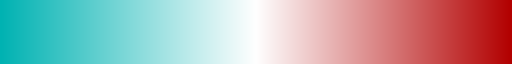

In [40]:
from bbtoolkit.utils.viz.colors import generate_cmap

red = '#b20000'
green = '#00b2b2'
cmap = generate_cmap(*[
    # '#003535',
    '#00b2b2',
    '#fff',
    '#b20000'
])
cmap

In [41]:
class DebugArtist(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'gc',
            'rates',
            'activity',
            'debug_ax1',
            'debug_ax1_1',
            'weights',
            'grid2cart',
            'movement_params',
            'encoding_params',
        ]
        cache['debug_ax1'] = cache['fig'].add_subplot(cache['gc'][8:10, 4:6])
        cache['debug_ax1_1'] = cache['fig'].add_subplot(cache['gc'][8:10, 6:8])
        cache['fig'].tight_layout()
        super().set_cache(cache, on_repeat=on_repeat)

    def on_plot(self):
        # self.debug_ax1.imshow(self.weights.ovc.to.opr, aspect='auto', origin='lower')
        self.debug_ax1.imshow(
            np.reshape(
                (self.weights.gc.to.h@self.rates.gc),
                self.grid2cart.shape
            ),
            cmap='coolwarm',
        )
        # self.debug_ax1.plot(self.activity.opr, 'o')
        temp = np.zeros(self.grid2cart.shape)
        temp[*self.grid2cart(*self.movement_params.position)] = 1
        self.debug_ax1_1.imshow(temp, cmap='coolwarm')

    def on_clean(self):
        self.debug_ax1.clear()

In [42]:
%matplotlib qt


logging.getLogger('matplotlib').setLevel(logging.WARNING)


dt = .005
# position = (-4, 7.5)
# position = (0, 0)
# position = (0, 0)
# position = (5, -5)
position = (7, -7)
direction = np.pi/2
# direction = -3*np.pi/4
attn_dist = 7.5

cache = BBCache(
    connectivity.copy(),
    weights.copy(),
    k_ratio.copy(),
    activity.copy(),
    rates.copy(),
    tc_gen,
    compiler.environment,
    Grid2CartTransition(compiler.environment),
    DynamicParameters(dt, 'bottom-up'),
    EcodingParameters(),
    ClickParameters()
)

cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
            )
        ),
        MentalPositionCallback(),
        MentalMovementCallback(
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        MentalMovementSchedulerCallback(),
        MentalTrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        AttentionCallback(
            DistanceAttention(7, dt, len(compiler.environment.objects), attn_dist)
        ),
        HDCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        PlottingCallback(
            [
                AloEnvPlotter(
                    attn_color=red
                ),
                EgoEnvPlotter(
                    attn_color=red
                ),
                MouseEventCallback(),
                TimerPlotter(),
                AgentPlotter(),
                TargetPlotter(
                    move_target_color=red
                ),
                TrajectoryPlotter(
                    target_color=red
                ),
                PWPlotter(cmap=cmap),
                BVCPlotter(cmap=cmap),
                oPWPlotter(cmap=cmap),
                OVCPlotter(cmap=cmap),
                HDPlotter(cmap=cmap),
                PCPlotter(cmap=cmap),
                oPRPlotter(
                    '#00b2b2',
                    '#b20000'
                ),
                ObjectRecallCallback(),
                PickedObjectPlotter(),
                DistanceAttentionPlotter(attn_dist, color=red),
                MentalAgentPlotter(),
                MentalTargetPlotter(),
                MentalTrajectoryPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

2024-05-19 16:12:25 - DEBUG - Loaded backend QtAgg version 6.7.0.
QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion


2024-05-19 16:12:27 - DEBUG - HD CUE INITIATED
2024-05-19 16:12:44 - DEBUG - HD CUE REMOVED


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-19 16:16:00 - DEBUG - Switch attention to 2
2024-05-19 16:16:12 - DEBUG - OVC2H FOR OBJECT 2 UPDATED
2024-05-19 16:16:12 - DEBUG - OVC2OPR FOR OBJECT 2 UPDATED
2024-05-19 16:16:12 - DEBUG - H2OPR FOR OBJECT 2 UPDATED
2024-05-19 16:16:12 - DEBUG - HD2OPR FOR OBJECT 2 UPDATED
2024-05-19 16:16:12 - DEBUG - BVC2OVC FOR OBJECT 2 UPDATED


ovc h 1.0 1.0
ovc opr 1.0 1.0
h opr 1.0 1.0
bvc ovc 1.0 1.0
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-19 16:17:13 - DEBUG - Switch attention to 4
2024-05-19 16:17:24 - DEBUG - OVC2H FOR OBJECT 4 UPDATED
2024-05-19 16:17:24 - DEBUG - OVC2OPR FOR OBJECT 4 UPDATED
2024-05-19 16:17:24 - DEBUG - H2OPR FOR OBJECT 4 UPDATED
2024-05-19 16:17:24 - DEBUG - HD2OPR FOR OBJECT 4 UPDATED
2024-05-19 16:17:24 - DEBUG - BVC2OVC FOR OBJECT 4 UPDATED


ovc h 1.0 1.0
ovc opr 1.0 1.0
h opr 1.0 1.0
bvc ovc 1.0 1.0


2024-05-19 16:17:30 - DEBUG - Switch attention to 2
2024-05-19 16:17:47 - DEBUG - Switch attention to 4
2024-05-19 16:18:03 - DEBUG - Switch attention to 2
2024-05-19 16:18:19 - DEBUG - Switch attention to 4


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-19 16:18:52 - DEBUG - Switch attention to 2
2024-05-19 16:19:08 - DEBUG - Switch attention to 4
2024-05-19 16:19:25 - DEBUG - Switch attention to 2
2024-05-19 16:19:42 - DEBUG - Switch attention to 4
2024-05-19 16:20:15 - DEBUG - Initiate recall for object 2


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-19 16:20:53 - DEBUG - Switching to top-down mode


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_most_visible_color(cmap):
    """
    Returns the hex code of the most visible color on the given colormap
    when viewed on a grayscale background.

    Args:
        cmap (str or Colormap): The colormap to analyze.

    Returns:
        str: The hex code of the most visible color.
    """
    # Ensure cmap is a Colormap instance
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)

    # Generate an array of points along the colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Convert colors to grayscale using the luminosity method
    # This method better represents human perception
    grayscale = 0.21 * colors[:, 0] + 0.72 * colors[:, 1] + 0.07 * colors[:, 2]

    # Find the color with the maximum contrast to the midpoint of the grayscale spectrum
    # The midpoint is 0.5 in normalized grayscale (0 is black, 1 is white)
    contrast = np.abs(grayscale - 0.5)
    max_contrast_index = np.argmax(contrast)

    # Convert the most visible color to hex format
    most_visible_color = colors[max_contrast_index]
    hex_color = matplotlib.colors.rgb2hex(most_visible_color[:3])

    return hex_color

# Example usage:
cmap_name = 'viridis'  # Change this to any colormap name you like
most_visible_color = get_most_visible_color(cmap)
print(f"The most visible color on the '{cmap_name}' colormap is: {most_visible_color}")

The most visible color on the 'viridis' colormap is: #fdfefe


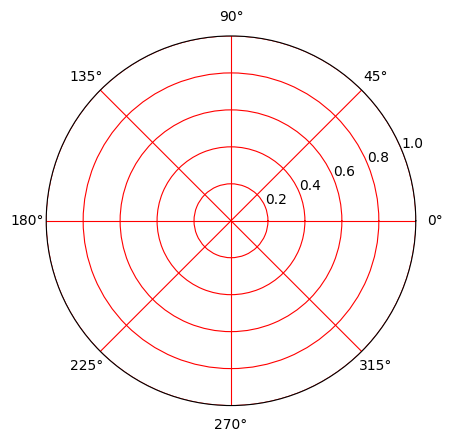

In [ ]:
fig = plt.figure()
%matplotlib inline
ax = fig.add_subplot(111, projection='polar')
ax.grid(color='red')
# ax.contourf(
#             self.theta_bvc.T,
#             self.r_bvc.T,
#             np.reshape(np.maximum(self.rates.ovc, 1e-7), (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
#             cmap=self.cmap,
#             vmin=0, vmax=1
#         )


In [ ]:
cache.weights.ovc.to.opr.max(), cache.weights.opr.to.ovc.max(), cache.weights['opr'].to['ovc'].max()

(1.0, 0.0, 1.0)

In [ ]:
cache.weights['hd'].to['hd'].shape

(100, 100)

In [ ]:
ObjectWeightsUpdatingCallback().population_thresholds.opr.to.ovc

{'threshold': 0.05, 'update_threshold': 0.05}

In [ ]:
vis = cache.rates.hd.copy()
th_indices = np.where(vis > .1)[0]
breakdown = np.where(np.diff(th_indices) != 1)[0]
if breakdown.size:
    th_indices = np.concatenate([th_indices[breakdown[0]+1:], th_indices[:breakdown[0]+1], ])

for i in range(len(th_indices)//2):
    this_index = ((i)+th_indices[len(th_indices)//2])%len(vis)
    next_index = (this_index + 1)%len(vis)
    temp = vis[next_index]
    vis[next_index] = vis[this_index]




IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
th_indices

array([95, 96, 97, 98, 99,  0,  1,  2])

In [ ]:
np.where(np.diff(np.where(np.array([1, 2]) > .1)[0]) != 1)[0].size

0

In [ ]:
vis[-1]

array([0.99108521])

In [ ]:
cache.weights.bvc.to.ovc.max()

1.0

In [ ]:
cache.weights.ovc.to.bvc = cache.weights.bvc.to.ovc.T

In [ ]:
cache.weights.opr.to.ovc = cache.weights.ovc.to.opr.T

In [ ]:
for _ in dynamics(True):
    print('out: ', _)

2024-05-18 19:48:28 - DEBUG - Stop recall
2024-05-18 19:48:29 - DEBUG - HD CUE INITIATED
2024-05-18 19:48:46 - DEBUG - HD CUE REMOVED
2024-05-18 19:49:03 - DEBUG - Initiate recall for object 2
2024-05-18 19:49:23 - DEBUG - Stop recall
2024-05-18 19:49:23 - DEBUG - HD CUE INITIATED
2024-05-18 19:49:40 - DEBUG - Initiate recall for object 2
2024-05-18 19:49:40 - DEBUG - HD CUE REMOVED


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


KeyboardInterrupt: 

In [ ]:
from bbtoolkit.preprocessing.environment.viz import make_video_from_images


image_directory = '../tmp'
video_save_path = './full_experiment.mp4'
make_video_from_images(image_directory, video_save_path, 4)

2024-05-15 23:14:43 - INFO - Video saved to ./full_experiment.mp4


In [ ]:
from bbtoolkit.data import remove_files_from_dir

image_directory = '../tmp'
remove_files_from_dir(image_directory)

2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_5.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_10.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_15.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_20.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_25.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_30.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_35.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_40.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_45.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_50.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_55.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_60.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_65.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_70.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_75.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_80.png
2024-05-15 22:06:29 - INFO - Removed: ../tmp/frame_85.png
2024-05-15 22:0

In [ ]:
dynamics.save('../data/dynamics.pkl')

In [ ]:
dynamics_pretrained.attention_params

AttributeError: 'DynamicsManager' object has no attribute 'attention_params'

In [ ]:
%matplotlib qt
dynamics_pretrained = DynamicsManager.load('../data/dynamics.pkl')
for _ in dynamics_pretrained(True):
    print('out: ', _)

EOFError: Ran out of input

In [ ]:
dynamics_pretrained.cache.attention_params

AttentionParams(attend_to=3, attention_priority=array([0., 0., 0., 0., 0.]), attention_step=21, attention_cycle=28)

In [ ]:
dynamics_pretrained.cache.objects_pw[dynamics_pretrained.cache.attention_params['attend_to']]

array(0, dtype=object)

In [ ]:
for i in range(len(dynamics_pretrained.cache.objects_pw)):
    dynamics_pretrained.cache.objects_pw[i] = dynamics.cache.objects_pw[i]